In [10]:
!unzip -q /content/drive/MyDrive/ColabNotebooks/nlp_project/N24News.zip # Extract the data from zip file

In [11]:
!wget https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py

--2024-05-06 21:07:40--  https://raw.githubusercontent.com/tylerneylon/explacy/master/explacy.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6896 (6.7K) [text/plain]
Saving to: ‘explacy.py.1’

explacy.py.1        100%[===================>]   6.73K  --.-KB/s    in 0s      

2024-05-06 21:07:40 (75.1 MB/s) - ‘explacy.py.1’ saved [6896/6896]



In [ ]:
!pip install -q datasets bert-score


### Import libraries

In [12]:
# Standard data manipulation libraries
import pandas as pd
import numpy as np

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# NLP libraries
import nltk
from nltk import PorterStemmer, WordNetLemmatizer
import spacy
from spacy import displacy
from spacy.util import minibatch, compounding
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Deep Learning & Transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification, BertTokenizer, BertTokenizerFast
from tqdm.notebook import tqdm

# Utilities and other libraries
from PIL import Image
import re


In [13]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

The Python Natural Language Toolkit (NLTK) is a set of libraries and programs designed for symbolic and statistical natural language processing. The commands:

- `nltk.download('stopwords')`: This command downloads a collection of "stop words". Stop words are words like "and", "the", "in", which are very common in the English language but usually do not contribute much meaning to a text. They are often removed from the text before performing tasks like text classification or sentiment analysis to improve the processing of relevant data.

- `nltk.download('wordnet')`: This command downloads WordNet, a large lexical database of English. WordNet is widely used in computational linguistics and natural language processing. It groups English words into sets of synonyms called synsets, provides short, general definitions, and records the various semantic relations between these synonym sets. It is useful for tasks such as word sense disambiguation, text analysis, and natural language understanding.


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load the Datasets & Explore

**the data is on jsopn format, So i convert it to dataframe using Pandas**

In [15]:
json_test_data = pd.read_json('/content/news/nytimes_test.json')
json_test_data.head()

section                                           headline  \
0       Travel  Afropunk, Huichica and More: 8 Music Festivals...   
1        Style                  The Repurposing of a Vogue Editor   
2  Real Estate                           Sites for Aviation Buffs   
3   Television  What's on TV Monday: 'Amy Schumer Learns to Co...   
4      Economy  Argentina Raises Key Rate to 40%, Bringing Eco...   

                                         article_url  \
0  https://www.nytimes.com/2019/03/15/travel/afro...   
1  https://www.nytimes.com/2019/04/09/style/tonne...   
2  https://www.nytimes.com/2016/12/13/realestate/...   
3  https://www.nytimes.com/2020/08/17/arts/televi...   
4  https://www.nytimes.com/2018/05/04/business/ec...   

                                             article  \
0  An act at the FORM festival, held at Arcosanti...   
1  Tonne Goodman has a mantra for when things sta...   
2  The Dayton area has more than a dozen sites fo...   
3  CHURCHILL: BLOOD, SWEAT & OIL PAINT (2015) Str...   
4  BUENOS AIRES -- Since his 2015 election, Presi...   

                                            abstract  \
0  Whether in the desert, the forest or a city, a...   
1  After almost 20 years at the magazine, Tonne G...   
2  The Dayton area has more than a dozen sites fo...   
3  The comedian's culinary apprenticeship continu...   
4  The move seeks to stabilize the country's curr...   

                             article_id  \
0  f756b8fa-24fb-587d-90ec-8eb834907433   
1  78a707f0-ceef-53c1-9ab3-0de5c5322fea   
2  754ce423-61e9-5d2e-90bf-dc847a39f0ee   
3  2a2bb2a5-d614-540d-b117-49e13b520063   
4  ee111efe-5583-5d14-bff8-6527244f3867   

                                               image  \
0  https://static01.nyt.com/images/2019/03/17/tra...   
1  https://static01.nyt.com/images/2019/04/11/fas...   
2  https://static01.nyt.com/images/2016/12/14/bus...   
3  https://static01.nyt.com/images/2020/08/17/art...   
4  https://static01.nyt.com/images/2018/05/05/bus...   

                                             caption  \
0                                    Anthony Pidgeon   
1  Ms. Goodman styled Amber Valletta with wings f...   
2  Alex Heckman, director of education and museum...   
3  Marital and culinary bliss: Chris Fischer and ...   
4  The central bank of Argentina said it would us...   

                               image_id  
0  f756b8fa-24fb-587d-90ec-8eb834907433  
1  78a707f0-ceef-53c1-9ab3-0de5c5322fea  
2  754ce423-61e9-5d2e-90bf-dc847a39f0ee  
3  2a2bb2a5-d614-540d-b117-49e13b520063  
4  ee111efe-5583-5d14-bff8-6527244f3867

In [16]:
json_train_data = pd.read_json('/content/news/nytimes_train.json')
json_train_data.head()

section                                           headline  \
0       Theater  Before 'Moonlight' and 'The Walking Dead,' a F...   
1    Television  What's on TV Wednesday: 'Crip Camp' and 'Dark ...   
2        Sports  Rays Stick to Their Plan and Reach a 2nd World...   
3  Art & Design    For Robert Rauschenberg, No Artist Is an Island   
4       Theater  Jimmy Buffett's 'Margaritaville' Musical Sets ...   

                                         article_url  \
0  https://www.nytimes.com/2017/02/21/theater/dan...   
1  https://www.nytimes.com/2020/03/25/arts/televi...   
2  https://www.nytimes.com/2020/10/17/sports/base...   
3  https://www.nytimes.com/2017/05/11/arts/design...   
4  https://www.nytimes.com/2017/06/05/theater/jim...   

                                             article  \
0  Danai Gurira and Andre Holland in a theater at...   
1  CRIP CAMP: A DISABILITY REVOLUTION (2020) Stre...   
2  The Tampa Bay Rays told Charlie Morton it woul...   
3  We tend to think of artists as natural loners,...   
4  Jimmy Buffett's tropical paradise will land in...   

                                            abstract  \
0  André Holland first saw Danai Gurira at New Yo...   
1  The documentary "Crip Camp: A Disability Revol...   
2  Guided by the club's strict principles, Manage...   
3  A writer travels from Brooklyn to Lafayette, L...   
4  "Escape to Margaritaville," which features new...   

                             article_id  \
0  952a8b15-63f6-5e41-8f23-82dfbb33d1fa   
1  67b1b62f-43ea-59d0-bf93-a94c11845820   
2  3da821ea-b93b-5a09-99d7-45e1711b73f0   
3  becf4474-d1fa-5722-b829-251530aa942b   
4  9511a127-e616-5bf5-80c6-553da4010c19   

                                               image  \
0  https://static01.nyt.com/images/2017/02/22/art...   
1  https://static01.nyt.com/images/2020/03/25/art...   
2  https://static01.nyt.com/images/2020/10/19/spo...   
3  https://static01.nyt.com/images/2017/05/14/art...   
4  https://static01.nyt.com/images/2017/06/06/art...   

                                             caption  \
0  Danai Gurira and André Holland in a theater at...   
1  Judy Heumann in &ldquo;Crip Camp: A Disability...   
2  The Rays celebrated after the final out of the...   
3  Robert Rauschenberg performing in "Pelican" in...   
4  Jimmy Buffett, performing in 2016. His musical...   

                               image_id  
0  952a8b15-63f6-5e41-8f23-82dfbb33d1fa  
1  67b1b62f-43ea-59d0-bf93-a94c11845820  
2  3da821ea-b93b-5a09-99d7-45e1711b73f0  
3  becf4474-d1fa-5722-b829-251530aa942b  
4  9511a127-e616-5bf5-80c6-553da4010c19

In [17]:
json_dataset_data = pd.read_json('/content/news/nytimes_dataset.json')
json_dataset_data.head()

section                                           headline  \
0      Health  F.D.A. Plans to Ban Most E-Cigarette Flavors b...   
1     Science  Meteor Showers in 2020 That Will Light Up Nigh...   
2     Science  Rocket Launches, Trips to Mars and More 2020 S...   
3  Television  What's on TV Wednesday: A Linda Ronstadt Doc a...   
4      Travel        New Cruise Ships to Set Sail for Antarctica   

                                            abstract  \
0  The tobacco and vaping industries and conserva...   
1  All year long, Earth passes through streams of...   
2  A year full of highs and lows in space just en...   
3  "Linda Ronstadt: The Sound of My Voice" airs o...   
4  Interested in the southernmost continent? Here...   

                                             caption  \
0  A new study by the National Institute on Drug ...   
1  Perseid meteors named as "Orinoid" streak acro...   
2  Spectators viewing the launch of a Soyuz rocke...   
3  Linda Ronstadt in "Linda Ronstadt: The Sound o...   
4  Antarctica21&rsquo;s expedition ship, Ocean No...   

                                           image_url  \
0  https://static01.nyt.com/images/2019/11/06/sci...   
1  https://static01.nyt.com/images/2020/01/01/sci...   
2  https://static01.nyt.com/images/2020/01/01/sci...   
3  https://static01.nyt.com/images/2020/01/01/art...   
4  https://static01.nyt.com/images/2020/01/05/tra...   

                                         article_url  \
0  https://www.nytimes.com/2019/12/31/health/e-ci...   
1  https://www.nytimes.com/2020/01/01/science/met...   
2  https://www.nytimes.com/2020/01/01/science/spa...   
3  https://www.nytimes.com/2020/01/01/arts/televi...   
4  https://www.nytimes.com/2020/01/01/travel/anta...   

                               image_id  
0  42d25485-0e48-50bf-8d16-948833b2a55d  
1  04bc90f0-b20b-511c-b5bb-3ce13194163f  
2  bd8647b3-8ec6-50aa-95cf-2b81ed12d2dd  
3  e6c25b53-0416-5795-b0cf-e1243924dc79  
4  98c3d182-95ce-5244-9b9e-008a3dee7354

In [19]:
# check the shape of each dataset
print(f'the shape of train data: {json_train_data.shape}\nthe shape of test data: {json_test_data.shape}\nthe shape of dataset data: {json_dataset_data.shape}')

the shape of train data: (48988, 9)
the shape of test data: (6124, 9)
the shape of dataset data: (61218, 7)


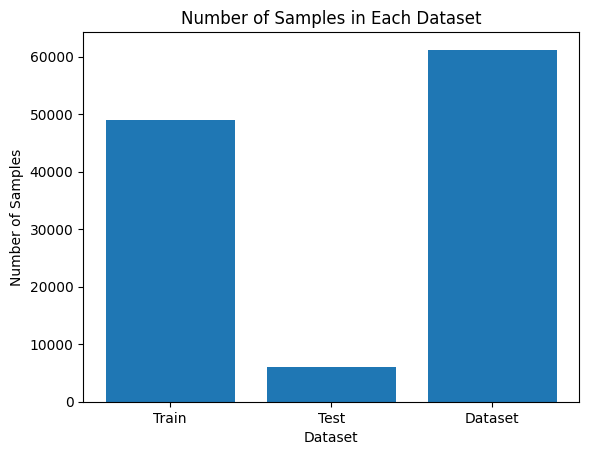

In [20]:
# Extract the number of samples from each dataset's shape
train_samples = json_train_data.shape[0]
test_samples = json_test_data.shape[0]
dataset_samples = json_dataset_data.shape[0]

# Create a bar chart
plt.bar(['Train', 'Test', 'Dataset'], [train_samples, test_samples, dataset_samples])

# Add labels and title
plt.xlabel('Dataset')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Dataset')

# Show the plot
plt.show()



- The dataset has the most samples, followed by the train dataset and then the test dataset.
- The difference in the number of samples between the train and test datasets big, but the test dataset is still large enough to be representative of the data.




In [21]:
for i in json_train_data.columns:
    row = json_train_data[i][0]
    print(f'{i} column\n{row}')

section column
Theater
headline column
Before 'Moonlight' and 'The Walking Dead,' a Friendship Born in the Classroom
article_url column
https://www.nytimes.com/2017/02/21/theater/danai-gurira-andre-holland-walking-dead.html
article column
Danai Gurira and Andre Holland in a theater at New York University, where they met in the Tisch Graduate Acting Program.

Behind every successful person are relationships that helped forge a path. But the stories of these friendships, collaborations, alliances, romances or rivalries often are lost in the glow of achievement. In this new feature, we explore a personal connection that made a difference in the lives of two artists. Andre Holland never thought much about writing his own monologues when he attended the Tisch graduate acting program at New York University. But one day, early in his first semester in 2003, he watched another African-American student, Danai Gurira, forgo the usual speeches by white characters and perform her own material inst

- Printing first row of each column, that give me ability to read all things in the row it self

In [22]:
json_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48988 entries, 0 to 48987
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   section      48988 non-null  object
 1   headline     48988 non-null  object
 2   article_url  48988 non-null  object
 3   article      48988 non-null  object
 4   abstract     48988 non-null  object
 5   article_id   48988 non-null  object
 6   image        48988 non-null  object
 7   caption      48988 non-null  object
 8   image_id     48988 non-null  object
dtypes: object(9)
memory usage: 3.4+ MB


- The train dataset contains 48988 rows and 9 columns.
- All columns are of type `object`.
- There are no null values in the dataset.

In [23]:
json_train_data.shape

(48988, 9)

In [24]:
json_train_data.isnull().sum()

section        0
headline       0
article_url    0
article        0
abstract       0
article_id     0
image          0
caption        0
image_id       0
dtype: int64

In [25]:
json_train_data['section'].describe()

count       48988
unique         24
top       Opinion
freq         2437
Name: section, dtype: object

- **Count**: There are 48,988 entries in the dataset.
- **Unique**: There are 24 unique categories or types within the data.
- **Top**: The most common category is 'Opinion'.
- **Frequency**: The 'Opinion' category appears 2,437 times, making it the most frequent category in the dataset.


In [26]:
# Show the count of each class or section in our case
print('Number of classes: ', json_train_data['section'].nunique())
json_train_data['section'].value_counts()

Number of classes:  24


section
Opinion            2437
Art & Design       2431
Television         2419
Music              2416
Travel             2413
Real Estate        2413
Books              2412
Theater            2409
Health             2409
Sports             2407
Science            2387
Fashion & Style    2385
Food               2385
Movies             2384
Technology         2376
Dance              2365
Media              2363
Style              2147
Automobiles        1456
Economy            1398
Your Money         1020
Global Business     955
Education           672
Well                529
Name: count, dtype: int64

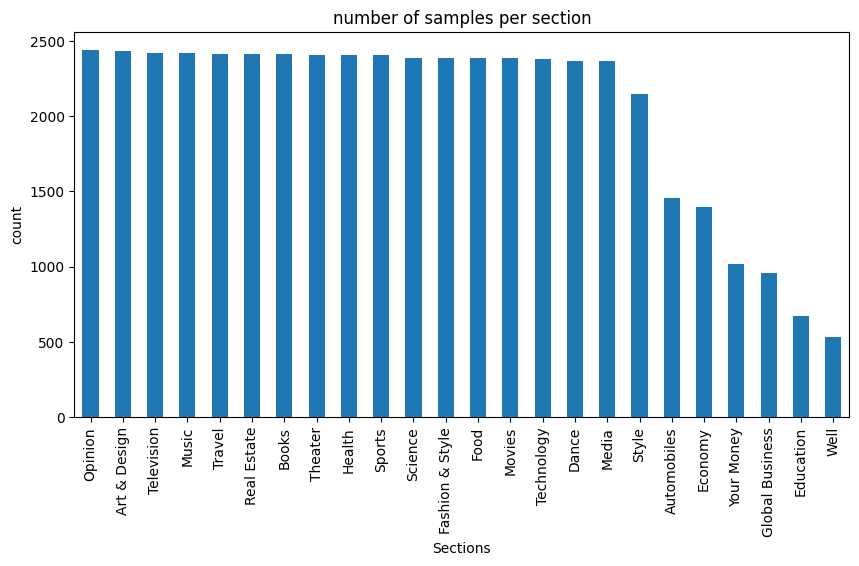

In [27]:
# Count the frequency of each unique value in the 'section' column of the json_train_data DataFrame.
frequency_counts = json_train_data['section'].value_counts()

# Set the size of the plot to 10 inches by 5 inches.
plt.figure(figsize = (10,5))

# Plot the frequency counts as a bar chart.
frequency_counts.plot(kind='bar')

# Label the x-axis as 'Sections'.
plt.xlabel('Sections')

# Label the y-axis as 'count'.
plt.ylabel('count')

# Set the title of the plot as 'number of samples per section'.
plt.title('number of samples per section')
plt.show()

---

### Data Distribution for Each Section

- Most sections have a **similar number of samples**; the dataset seems balanced.
- A **gradual decrease** in samples starts from the 'Media' section.
- 'Education' and 'Well' sections have the **fewest samples**, which may affect model training.
- **Class imbalance** could be a concern for sections with fewer samples.


---

In [28]:
# Get the number of words per sample
print("the average number of words per section: " ,np.mean(json_train_data['article'].apply(lambda x: len(x.split()))))

the average number of words per section:  788.8665999836695


In [29]:
# Create a copy of the json_train_data DataFrame to avoid modifying the original data.
train_data = json_train_data.copy()

# Add a new column 'word_count' to the train_data DataFrame. This column contains the count of words in each article,
# calculated by splitting the 'article' text into words (default split is on whitespace) and measuring the length of the resulting list.
train_data['word_count'] = train_data['article'].apply(lambda x: len(x.split()))

# Display the first few rows of the train_data DataFrame to check the new 'word_count' column and other data.
train_data.head()


section                                           headline  \
0       Theater  Before 'Moonlight' and 'The Walking Dead,' a F...   
1    Television  What's on TV Wednesday: 'Crip Camp' and 'Dark ...   
2        Sports  Rays Stick to Their Plan and Reach a 2nd World...   
3  Art & Design    For Robert Rauschenberg, No Artist Is an Island   
4       Theater  Jimmy Buffett's 'Margaritaville' Musical Sets ...   

                                         article_url  \
0  https://www.nytimes.com/2017/02/21/theater/dan...   
1  https://www.nytimes.com/2020/03/25/arts/televi...   
2  https://www.nytimes.com/2020/10/17/sports/base...   
3  https://www.nytimes.com/2017/05/11/arts/design...   
4  https://www.nytimes.com/2017/06/05/theater/jim...   

                                             article  \
0  Danai Gurira and Andre Holland in a theater at...   
1  CRIP CAMP: A DISABILITY REVOLUTION (2020) Stre...   
2  The Tampa Bay Rays told Charlie Morton it woul...   
3  We tend to think of artists as natural loners,...   
4  Jimmy Buffett's tropical paradise will land in...   

                                            abstract  \
0  André Holland first saw Danai Gurira at New Yo...   
1  The documentary "Crip Camp: A Disability Revol...   
2  Guided by the club's strict principles, Manage...   
3  A writer travels from Brooklyn to Lafayette, L...   
4  "Escape to Margaritaville," which features new...   

                             article_id  \
0  952a8b15-63f6-5e41-8f23-82dfbb33d1fa   
1  67b1b62f-43ea-59d0-bf93-a94c11845820   
2  3da821ea-b93b-5a09-99d7-45e1711b73f0   
3  becf4474-d1fa-5722-b829-251530aa942b   
4  9511a127-e616-5bf5-80c6-553da4010c19   

                                               image  \
0  https://static01.nyt.com/images/2017/02/22/art...   
1  https://static01.nyt.com/images/2020/03/25/art...   
2  https://static01.nyt.com/images/2020/10/19/spo...   
3  https://static01.nyt.com/images/2017/05/14/art...   
4  https://static01.nyt.com/images/2017/06/06/art...   

                                             caption  \
0  Danai Gurira and André Holland in a theater at...   
1  Judy Heumann in &ldquo;Crip Camp: A Disability...   
2  The Rays celebrated after the final out of the...   
3  Robert Rauschenberg performing in "Pelican" in...   
4  Jimmy Buffett, performing in 2016. His musical...   

                               image_id  word_count  
0  952a8b15-63f6-5e41-8f23-82dfbb33d1fa        1202  
1  67b1b62f-43ea-59d0-bf93-a94c11845820         479  
2  3da821ea-b93b-5a09-99d7-45e1711b73f0        1148  
3  becf4474-d1fa-5722-b829-251530aa942b        1179  
4  9511a127-e616-5bf5-80c6-553da4010c19          97

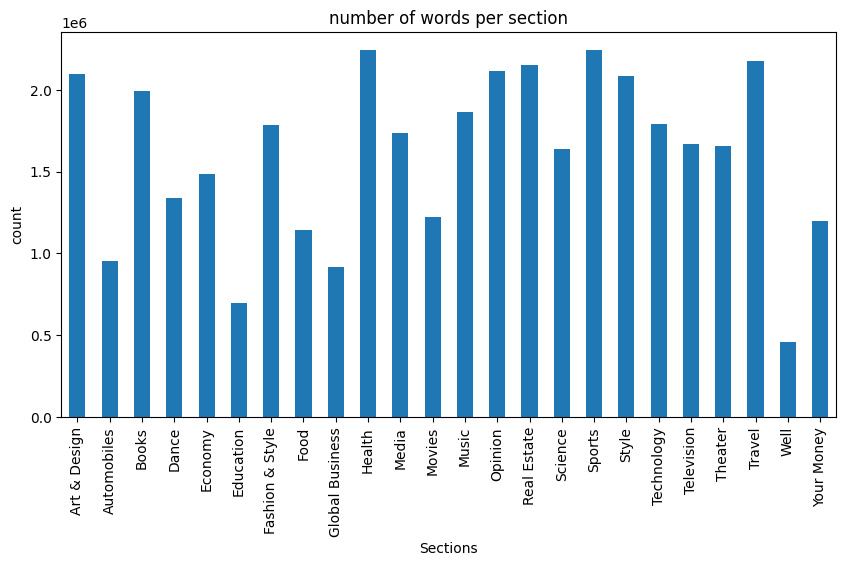

In [30]:
# Calculate the total number of words in each 'section' by grouping the 'train_data' DataFrame by 'section',
# then summing up the 'word_count' for each group.
category_word_counts = train_data.groupby('section')['word_count'].sum()

# Assign the sum of word counts per section to 'frequency_counts' for easier reference and plotting.
frequency_counts = category_word_counts

# Set the size of the plot to 10 inches by 5 inches.
plt.figure(figsize = (10,5))

# Plot the frequency counts as a bar chart, which shows the total number of words for each section.
frequency_counts.plot(kind='bar')

# Label the x-axis as 'Sections'.
plt.xlabel('Sections')

# Label the y-axis as 'count', representing the total number of words in each section.
plt.ylabel('count')

# Set the title of the plot as 'number of words per section'.
plt.title('number of words per section')
plt.show()


---

### Summary of Words Distribution by Section

- There's a **wide variation** in total word counts across different sections.
- Some sections, like **Art & Design and Opinion**, have a **high word count**, suggesting more extensive coverage or longer articles on average.
- Sections such as **Education, Dance, and Food** show **moderately lower word counts**.
- The **"Well"** section has the **lowest total word count**, indicating fewer or shorter articles in this category.


- **Imbalance Impact**: High word counts in some sections might bias a classification model.
- **Data Features**: More words per section could mean more detailed language features to learn from.
- **Class Balance**: Might need strategies to balance classes for fair learning.
- **Performance Concerns**: Sections with fewer words could be harder for the model to learn accurately.
- **Data Boosting**: Consider augmenting data in sections with low word counts.
- **Metrics for Evaluation**: Use detailed metrics to evaluate model performance fairly across all sections.

---

---

## Text cleaning and processing steps-

- Remove **punctuations**
- Convert text to **tokens**
- Remove **stopwords** using 'NLTK' corpus stopwords list to match
- Apply **stemming**
- Apply **lemmatization**
- Convert words to **feature vectors**
---

In [31]:
# Create a new DataFrame 'level_1' from 'train_data' that includes only the 'section' and 'article' columns.
level_1 = train_data[['section', 'article']]
level_1.head()

section                                            article
0       Theater  Danai Gurira and Andre Holland in a theater at...
1    Television  CRIP CAMP: A DISABILITY REVOLUTION (2020) Stre...
2        Sports  The Tampa Bay Rays told Charlie Morton it woul...
3  Art & Design  We tend to think of artists as natural loners,...
4       Theater  Jimmy Buffett's tropical paradise will land in...

---

- **Removes Punctuation**: Clears special characters like commas and periods.
- **Removes Numbers**: Takes out any digits.
- **Lowercases Text**: Converts all letters to lowercase for consistency.

---

In [33]:
# Function to clean and preprocess text
def clean_text(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

In [34]:
# Apply the cleaning function to the article column
level_1['cleaned_article'] = level_1['article'].apply(clean_text)
level_1.head()


<ipython-input-34-3e8ef1de1962>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_1['cleaned_article'] = level_1['article'].apply(clean_text)


section                                            article  \
0       Theater  Danai Gurira and Andre Holland in a theater at...   
1    Television  CRIP CAMP: A DISABILITY REVOLUTION (2020) Stre...   
2        Sports  The Tampa Bay Rays told Charlie Morton it woul...   
3  Art & Design  We tend to think of artists as natural loners,...   
4       Theater  Jimmy Buffett's tropical paradise will land in...   

                                     cleaned_article  
0  danai gurira and andre holland in a theater at...  
1  crip camp a disability revolution  stream on n...  
2  the tampa bay rays told charlie morton it woul...  
3  we tend to think of artists as natural loners ...  
4  jimmy buffetts tropical paradise will land in ...

In [35]:
# Define a function 'tokenize' that takes a text string as input.
def tokenize(text):
    # Split the text string into tokens based on one or more whitespace characters.
    text = re.split('\s+' ,text)
    # Return the list of tokens.
    return [x for x in text]

In [36]:
# Apply the 'tokenize' function to each entry in the 'cleaned_article' column of the 'level_1' DataFrame.
# Store the result in a new column 'tokens' in the same DataFrame.
level_1['tokens'] = level_1['cleaned_article'].apply(lambda msg: tokenize(msg))
level_1.head()

<ipython-input-36-feac962be9e3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_1['tokens'] = level_1['cleaned_article'].apply(lambda msg: tokenize(msg))


section                                            article  \
0       Theater  Danai Gurira and Andre Holland in a theater at...   
1    Television  CRIP CAMP: A DISABILITY REVOLUTION (2020) Stre...   
2        Sports  The Tampa Bay Rays told Charlie Morton it woul...   
3  Art & Design  We tend to think of artists as natural loners,...   
4       Theater  Jimmy Buffett's tropical paradise will land in...   

                                     cleaned_article  \
0  danai gurira and andre holland in a theater at...   
1  crip camp a disability revolution  stream on n...   
2  the tampa bay rays told charlie morton it woul...   
3  we tend to think of artists as natural loners ...   
4  jimmy buffetts tropical paradise will land in ...   

                                              tokens  
0  [danai, gurira, and, andre, holland, in, a, th...  
1  [crip, camp, a, disability, revolution, stream...  
2  [the, tampa, bay, rays, told, charlie, morton,...  
3  [we, tend, to, think, of, artists, as, natural...  
4  [jimmy, buffetts, tropical, paradise, will, la...

In [37]:
# Import the stop words list from spaCy's English language class.
from spacy.lang.en.stop_words import STOP_WORDS as SPACY_STOP_WORDS
# Import the English language class from spaCy which can be used to create language processing pipelines.
from spacy.lang.en import English

# Define a function to remove stopwords from a list of tokens using spaCy's list of English stop words.
def remove_stopwords_spacy(token_list, stopwords=SPACY_STOP_WORDS):
    # Use a list comprehension to filter out any words in the token list that are also in the stopwords list.
    filtered_tokens = [word for word in token_list if word not in stopwords]
    return filtered_tokens

In [38]:
# Apply the remove_stopwords_spacy function to each entry in the 'tokens' column of the level_1 DataFrame.
# This operation will create a new column 'clean_tokens' which contains the lists of tokens with stopwords removed.
level_1['clean_tokens'] = level_1['tokens'].apply(lambda x : remove_stopwords_spacy(x))
level_1.head()

<ipython-input-38-44434d88a8f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_1['clean_tokens'] = level_1['tokens'].apply(lambda x : remove_stopwords_spacy(x))


section                                            article  \
0       Theater  Danai Gurira and Andre Holland in a theater at...   
1    Television  CRIP CAMP: A DISABILITY REVOLUTION (2020) Stre...   
2        Sports  The Tampa Bay Rays told Charlie Morton it woul...   
3  Art & Design  We tend to think of artists as natural loners,...   
4       Theater  Jimmy Buffett's tropical paradise will land in...   

                                     cleaned_article  \
0  danai gurira and andre holland in a theater at...   
1  crip camp a disability revolution  stream on n...   
2  the tampa bay rays told charlie morton it woul...   
3  we tend to think of artists as natural loners ...   
4  jimmy buffetts tropical paradise will land in ...   

                                              tokens  \
0  [danai, gurira, and, andre, holland, in, a, th...   
1  [crip, camp, a, disability, revolution, stream...   
2  [the, tampa, bay, rays, told, charlie, morton,...   
3  [we, tend, to, think, of, artists, as, natural...   
4  [jimmy, buffetts, tropical, paradise, will, la...   

                                        clean_tokens  
0  [danai, gurira, andre, holland, theater, new, ...  
1  [crip, camp, disability, revolution, stream, n...  
2  [tampa, bay, rays, told, charlie, morton, happ...  
3  [tend, think, artists, natural, loners, studio...  
4  [jimmy, buffetts, tropical, paradise, land, ch...

In [39]:
# Apply stemming to get root words
def stemming(text):
    ps = PorterStemmer()
    return [ps.stem(word) for word in text]

In [40]:
# Apply the stemming function to each entry in the 'clean_tokens' column of the level_1 DataFrame.
# This operation will create a new column 'stem_words' which contains the lists of tokens with stopwords removed.
level_1['stem_words'] = level_1['clean_tokens'].apply(lambda wrd: stemming(wrd))
level_1.head()

<ipython-input-40-cc99b8c7de29>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_1['stem_words'] = level_1['clean_tokens'].apply(lambda wrd: stemming(wrd))


section                                            article  \
0       Theater  Danai Gurira and Andre Holland in a theater at...   
1    Television  CRIP CAMP: A DISABILITY REVOLUTION (2020) Stre...   
2        Sports  The Tampa Bay Rays told Charlie Morton it woul...   
3  Art & Design  We tend to think of artists as natural loners,...   
4       Theater  Jimmy Buffett's tropical paradise will land in...   

                                     cleaned_article  \
0  danai gurira and andre holland in a theater at...   
1  crip camp a disability revolution  stream on n...   
2  the tampa bay rays told charlie morton it woul...   
3  we tend to think of artists as natural loners ...   
4  jimmy buffetts tropical paradise will land in ...   

                                              tokens  \
0  [danai, gurira, and, andre, holland, in, a, th...   
1  [crip, camp, a, disability, revolution, stream...   
2  [the, tampa, bay, rays, told, charlie, morton,...   
3  [we, tend, to, think, of, artists, as, natural...   
4  [jimmy, buffetts, tropical, paradise, will, la...   

                                        clean_tokens  \
0  [danai, gurira, andre, holland, theater, new, ...   
1  [crip, camp, disability, revolution, stream, n...   
2  [tampa, bay, rays, told, charlie, morton, happ...   
3  [tend, think, artists, natural, loners, studio...   
4  [jimmy, buffetts, tropical, paradise, land, ch...   

                                          stem_words  
0  [danai, gurira, andr, holland, theater, new, y...  
1  [crip, camp, disabl, revolut, stream, netflix,...  
2  [tampa, bay, ray, told, charli, morton, happen...  
3  [tend, think, artist, natur, loner, studio, wr...  
4  [jimmi, buffett, tropic, paradis, land, chilli...

In [41]:
# Apply lemmatization on tokens
def lemmatize(text):
    word_net = WordNetLemmatizer()
    return [word_net.lemmatize(word) for word in text]

In [42]:
# Apply the lemmatize function to each entry in the 'clean_tokens' column of the level_1 DataFrame.
# This operation will create a new column 'lemma_words' which contains the lists of tokens with stopwords removed.
level_1['lemma_words'] = level_1['clean_tokens'].apply(lambda x : lemmatize(x))
level_1.head()

<ipython-input-42-bfc6e69e434d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_1['lemma_words'] = level_1['clean_tokens'].apply(lambda x : lemmatize(x))


section                                            article  \
0       Theater  Danai Gurira and Andre Holland in a theater at...   
1    Television  CRIP CAMP: A DISABILITY REVOLUTION (2020) Stre...   
2        Sports  The Tampa Bay Rays told Charlie Morton it woul...   
3  Art & Design  We tend to think of artists as natural loners,...   
4       Theater  Jimmy Buffett's tropical paradise will land in...   

                                     cleaned_article  \
0  danai gurira and andre holland in a theater at...   
1  crip camp a disability revolution  stream on n...   
2  the tampa bay rays told charlie morton it woul...   
3  we tend to think of artists as natural loners ...   
4  jimmy buffetts tropical paradise will land in ...   

                                              tokens  \
0  [danai, gurira, and, andre, holland, in, a, th...   
1  [crip, camp, a, disability, revolution, stream...   
2  [the, tampa, bay, rays, told, charlie, morton,...   
3  [we, tend, to, think, of, artists, as, natural...   
4  [jimmy, buffetts, tropical, paradise, will, la...   

                                        clean_tokens  \
0  [danai, gurira, andre, holland, theater, new, ...   
1  [crip, camp, disability, revolution, stream, n...   
2  [tampa, bay, rays, told, charlie, morton, happ...   
3  [tend, think, artists, natural, loners, studio...   
4  [jimmy, buffetts, tropical, paradise, land, ch...   

                                          stem_words  \
0  [danai, gurira, andr, holland, theater, new, y...   
1  [crip, camp, disabl, revolut, stream, netflix,...   
2  [tampa, bay, ray, told, charli, morton, happen...   
3  [tend, think, artist, natur, loner, studio, wr...   
4  [jimmi, buffett, tropic, paradis, land, chilli...   

                                         lemma_words  
0  [danai, gurira, andre, holland, theater, new, ...  
1  [crip, camp, disability, revolution, stream, n...  
2  [tampa, bay, ray, told, charlie, morton, happe...  
3  [tend, think, artist, natural, loner, studio, ...  
4  [jimmy, buffetts, tropical, paradise, land, ch...

In [ ]:
# Define a function `return_sentences` that takes a list of tokenized words ('tokens') and joins them into a single string (sentence).
# This function is used to convert lists of words back into string format.
def return_sentences(tokens):
    return " ".join([word for word in tokens])

In [ ]:
# Apply the `return_sentences` function to each entry in the 'lemma_words' column of the 'level_1' DataFrame.
# This converts lists of lemmatized words back into cleaned text strings. Store these strings in a new column called 'clean_text'.
level_1['clean_text'] = level_1['lemma_words'].apply(lambda x : return_sentences(x))
level_1.head()

<ipython-input-36-50f09a24c330>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  level_1['clean_text'] = level_1['lemma_words'].apply(lambda x : return_sentences(x))


section                                            article  \
0       Theater  Danai Gurira and Andre Holland in a theater at...   
1    Television  CRIP CAMP: A DISABILITY REVOLUTION (2020) Stre...   
2        Sports  The Tampa Bay Rays told Charlie Morton it woul...   
3  Art & Design  We tend to think of artists as natural loners,...   
4       Theater  Jimmy Buffett's tropical paradise will land in...   

                                     cleaned_article  \
0  danai gurira and andre holland in a theater at...   
1  crip camp a disability revolution  stream on n...   
2  the tampa bay rays told charlie morton it woul...   
3  we tend to think of artists as natural loners ...   
4  jimmy buffetts tropical paradise will land in ...   

                                              tokens  \
0  [danai, gurira, and, andre, holland, in, a, th...   
1  [crip, camp, a, disability, revolution, stream...   
2  [the, tampa, bay, rays, told, charlie, morton,...   
3  [we, tend, to, think, of, artists, as, natural...   
4  [jimmy, buffetts, tropical, paradise, will, la...   

                                        clean_tokens  \
0  [danai, gurira, andre, holland, theater, new, ...   
1  [crip, camp, disability, revolution, stream, n...   
2  [tampa, bay, rays, told, charlie, morton, happ...   
3  [tend, think, artists, natural, loners, studio...   
4  [jimmy, buffetts, tropical, paradise, land, ch...   

                                          stem_words  \
0  [danai, gurira, andr, holland, theater, new, y...   
1  [crip, camp, disabl, revolut, stream, netflix,...   
2  [tampa, bay, ray, told, charli, morton, happen...   
3  [tend, think, artist, natur, loner, studio, wr...   
4  [jimmi, buffett, tropic, paradis, land, chilli...   

                                         lemma_words  \
0  [danai, gurira, andre, holland, theater, new, ...   
1  [crip, camp, disability, revolution, stream, n...   
2  [tampa, bay, ray, told, charlie, morton, happe...   
3  [tend, think, artist, natural, loner, studio, ...   
4  [jimmy, buffetts, tropical, paradise, land, ch...   

                                          clean_text  
0  danai gurira andre holland theater new york un...  
1  crip camp disability revolution stream netflix...  
2  tampa bay ray told charlie morton happen chase...  
3  tend think artist natural loner studio wrestli...  
4  jimmy buffetts tropical paradise land chilly n...

In [ ]:
# Load the small English model from spaCy, which includes vocabulary, syntax, and entities for processing English text.
spacy_tok = spacy.load('en_core_web_sm')

# Use the explacy tool to print parsing information for the sentence 'He played football everyday with his motehr.'
# This includes details like part-of-speech tags, dependencies, and lemmas, helping to visualize the structure and errors in the sentence.
explacy.print_parse_info(spacy_tok, 'He played football everyday with his motehr.')


Dep tree   Token    Dep type Lemma    Part of Sp
────────── ──────── ──────── ──────── ──────────
       ┌─► He       nsubj    he       PRON      
┌┬────┬┼── played   ROOT     play     VERB      
││    │└─► football dobj     football NOUN      
││    └──► everyday npadvmod everyday ADV       
│└─►┌───── with     prep     with     ADP       
│   │  ┌─► his      poss     his      PRON      
│   └─►└── motehr   pobj     motehr   NOUN      
└────────► .        punct    .        PUNCT     


---

### Dependency Tree Analysis for "He played football every day with his mother."

#### 1. **Dep Tree Token**
This column shows the hierarchical structure of the sentence, indicating how each word (token) is connected to others in terms of dependency relations:
- Arrows indicate dependency links, pointing from a word to its head (the word it depends on).
- The structure shows how words are nested or linked, with indentation helping to visualize these relationships.

#### 2. **Dep Type (Dependency Type)**
This column specifies the type of dependency relationship between a word and its head:
- **nsubj (nominal subject)**: "He" is the subject of the verb "played."
- **ROOT**: The verb "played" is the root of the sentence, meaning that other words in the sentence depend on it.
- **dobj (direct object)**: "football" is the direct object of the verb "played," indicating what is being played.
- **npadvmod (noun phrase as adverbial modifier)**: "everyday" modifies the verb "played," describing when the playing occurs.
- **prep (prepositional modifier)**: "with" introduces the prepositional phrase describing the accompaniment.
- **poss (possessive modifier)**: "his" modifies "mother," indicating possession.
- **pobj (prepositional object)**: "mother" is the object of the preposition "with," completing the idea of who he played with.
- **punct (punctuation)**: The period "." signifies the end of the sentence.

#### 3. **Lemma**
This column shows the lemma of each word, which is the base or dictionary form of the word:
- **he**: Lemma for the pronoun "He."
- **play**: Lemma of "played," reflecting the base form of the verb.
- **football**: Same as the word, indicating it's a noun in its base form.
- **everyday**: Same as the word, indicating it's an adverb in its base form.
- **with**: Lemma for the preposition "with."
- **his**: Lemma for the possessive pronoun "his."
- **mother**: Corrected lemma of "mother," the noun "mother."
- **.**: Punctuation marks typically do not have lemmas.

#### 4. **Part of Sp (Part of Speech)**
This column categorizes each word by its part of speech:
- **PRON (pronoun)**: "He" and "his" are pronouns.
- **VERB**: "Played" is a verb, the main action in the sentence.
- **NOUN**: "Football" and "mother" are nouns, representing the main objects in the sentence.
- **ADV (adverb)**: "Everyday" is an adverb, describing the frequency of the action.
- **ADP (adposition, typically preposition)**: "with" is a preposition, indicating a relationship between "he" and "mother."
- **PUNCT (punctuation)**: "." marks the end of the sentence.

---

In [ ]:
# Load the English NLP model
nlp = spacy.load('en_core_web_sm')

text_ = "He played football every Day's with (his) mother."

# Process the text using the spaCy NLP pipeline
doc = nlp(text_)
doc

/usr/local/lib/python3.10/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


He played football every Day's with (his) mother.

In [ ]:

# Initialize an empty DataFrame
tokenized_text = pd.DataFrame()

# Iterate over the tokens in the document
for i, token in enumerate(doc):
    tokenized_text.loc[i, 'text'] = token.text
    tokenized_text.loc[i, 'lemma'] = token.lemma_
    tokenized_text.loc[i, 'pos'] = token.pos_
    tokenized_text.loc[i, 'tag'] = token.tag_
    tokenized_text.loc[i, 'dep'] = token.dep_
    tokenized_text.loc[i, 'shape'] = token.shape_
    tokenized_text.loc[i, 'is_alpha'] = token.is_alpha
    tokenized_text.loc[i, 'is_stop'] = token.is_stop
    tokenized_text.loc[i, 'is_punctuation'] = token.is_punct

# Display the DataFrame
tokenized_text

text     lemma    pos    tag       dep shape is_alpha is_stop  \
0         He        he   PRON    PRP     nsubj    Xx     True    True   
1     played      play   VERB    VBD      ROOT  xxxx     True   False   
2   football  football   NOUN     NN      dobj  xxxx     True   False   
3      every     every    DET     DT       det  xxxx     True    True   
4        Day       Day  PROPN    NNP  npadvmod   Xxx     True   False   
5         's        's   PART    POS      case    'x    False    True   
6       with      with    ADP     IN      prep  xxxx     True    True   
7          (         (  PUNCT  -LRB-     punct     (    False   False   
8        his       his   PRON   PRP$      poss   xxx     True    True   
9          )         )  PUNCT  -RRB-     punct     )    False   False   
10    mother    mother   NOUN     NN      pobj  xxxx     True   False   
11         .         .  PUNCT      .     punct     .    False   False   

   is_punctuation  
0           False  
1           False  
2           False  
3           False  
4           False  
5           False  
6           False  
7            True  
8           False  
9            True  
10          False  
11           True

In [ ]:
text_list = list(doc.sents)
text_list

[He played football every Day's with (his) mother.,
 And his name is Tony and he is from UK]

In [ ]:
displacy.render(text_list, style='dep', jupyter=True,options={'distance': 140})

In [ ]:
import spacy
from spacy import displacy

# Load the English NLP model
nlp = spacy.load('en_core_web_sm')

# Your text
text_ = "He played football every Day's with (his) mother. And his name is Tony and he is from UK"

# Process the text with the spaCy model to create a Doc object
doc = nlp(text_)

# Now use displacy to render the entities, make sure you pass the Doc object, not the text string
displacy.render(doc, style='ent', jupyter=True)

---

### Named Entity Recognition (NER)

Named Entity Recognition (NER) identifies real-world objects such as Persons, Organizations, etc., from text. spaCy can automatically detect various types of entities:

#### Entity Types and Descriptions

| Type         | Description |
|--------------|-------------|
| **PERSON**   | People, including fictional. |
| **NORP**     | Nationalities or religious or political groups. |
| **FAC**      | Buildings, airports, highways, bridges, etc. |
| **ORG**      | Companies, agencies, institutions, etc. |
| **GPE**      | Countries, cities, states. |
| **LOC**      | Non-GPE locations, mountain ranges, bodies of water. |
| **PRODUCT**  | Objects, vehicles, foods, etc. (Not services.) |
| **EVENT**    | Named hurricanes, battles, wars, sports events, etc. |
| **WORK_OF_ART** | Titles of books, songs, etc. |
| **LAW**      | Named documents made into laws. |
| **LANGUAGE** | Any named language. |
| **DATE**     | Absolute or relative dates or periods. |
| **TIME**     | Times smaller than a day. |
| **PERCENT**  | Percentage, including "%". |
| **MONEY**    | Monetary values, including unit. |
| **QUANTITY** | Measurements, as of weight or distance. |
| **ORDINAL**  | "first", "second", etc. |
| **CARDINAL** | Numerals that do not fall under another type. |

---

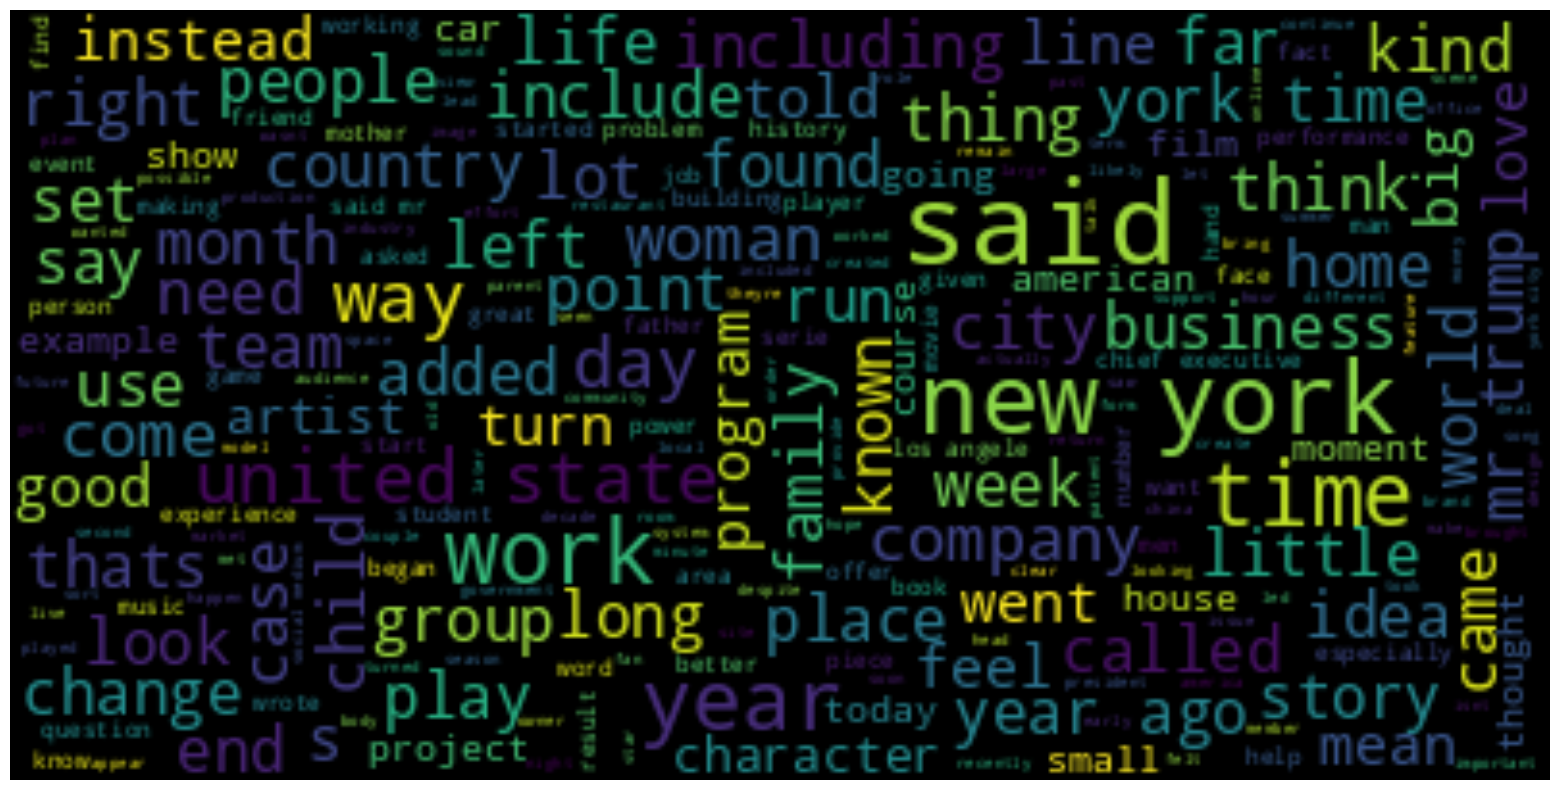

In [ ]:
# Generate a basic word cloud
from wordcloud import WordCloud, ImageColorGenerator

# Convert all non-string data to strings and handle missing values
text = " ".join(str(item) for item in level_1['clean_text'] if item is not None)

# Generate a basic word cloud
wordcloud = WordCloud(max_font_size=30, max_words=1000).generate(text)

# Display the generated image:
plt.figure(figsize=[20, 10])
plt.imshow(wordcloud, interpolation='bilinear')  # 'bilinear' interpolation improves the display quality
plt.axis("off")
plt.show()

- The most frequent words in the text are "new", "york", "city", "said", "time", "people", "year", "world", "state", and "government".
- Overall, the word cloud provides a good overview of the most frequent words in the text.

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
level_1['section_encoded'] = label_encoder.fit_transform(level_1['section'])
level_1.head()

section                                            article  \
0       Theater  Danai Gurira and Andre Holland in a theater at...   
1    Television  CRIP CAMP: A DISABILITY REVOLUTION (2020) Stre...   
2        Sports  The Tampa Bay Rays told Charlie Morton it woul...   
3  Art & Design  We tend to think of artists as natural loners,...   
4       Theater  Jimmy Buffett's tropical paradise will land in...   

                                     cleaned_article  \
0  danai gurira and andre holland in a theater at...   
1  crip camp a disability revolution  stream on n...   
2  the tampa bay rays told charlie morton it woul...   
3  we tend to think of artists as natural loners ...   
4  jimmy buffetts tropical paradise will land in ...   

                                              tokens  \
0  ['danai', 'gurira', 'and', 'andre', 'holland',...   
1  ['crip', 'camp', 'a', 'disability', 'revolutio...   
2  ['the', 'tampa', 'bay', 'rays', 'told', 'charl...   
3  ['we', 'tend', 'to', 'think', 'of', 'artists',...   
4  ['jimmy', 'buffetts', 'tropical', 'paradise', ...   

                                        clean_tokens  \
0  ['danai', 'gurira', 'andre', 'holland', 'theat...   
1  ['crip', 'camp', 'disability', 'revolution', '...   
2  ['tampa', 'bay', 'rays', 'told', 'charlie', 'm...   
3  ['tend', 'think', 'artists', 'natural', 'loner...   
4  ['jimmy', 'buffetts', 'tropical', 'paradise', ...   

                                          stem_words  \
0  ['danai', 'gurira', 'andr', 'holland', 'theate...   
1  ['crip', 'camp', 'disabl', 'revolut', 'stream'...   
2  ['tampa', 'bay', 'ray', 'told', 'charli', 'mor...   
3  ['tend', 'think', 'artist', 'natur', 'loner', ...   
4  ['jimmi', 'buffett', 'tropic', 'paradis', 'lan...   

                                         lemma_words  \
0  ['danai', 'gurira', 'andre', 'holland', 'theat...   
1  ['crip', 'camp', 'disability', 'revolution', '...   
2  ['tampa', 'bay', 'ray', 'told', 'charlie', 'mo...   
3  ['tend', 'think', 'artist', 'natural', 'loner'...   
4  ['jimmy', 'buffetts', 'tropical', 'paradise', ...   

                                          clean_text  section_encoded  
0  danai gurira andre holland theater new york un...               20  
1  crip camp disability revolution stream netflix...               19  
2  tampa bay ray told charlie morton happen chase...               16  
3  tend think artist natural loner studio wrestli...                0  
4  jimmy buffetts tropical paradise land chilly n...               20

In [ ]:
# Getting the mapping from encoded labels to original labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'Art & Design': 0, 'Automobiles': 1, 'Books': 2, 'Dance': 3, 'Economy': 4, 'Education': 5, 'Fashion & Style': 6, 'Food': 7, 'Global Business': 8, 'Health': 9, 'Media': 10, 'Movies': 11, 'Music': 12, 'Opinion': 13, 'Real Estate': 14, 'Science': 15, 'Sports': 16, 'Style': 17, 'Technology': 18, 'Television': 19, 'Theater': 20, 'Travel': 21, 'Well': 22, 'Your Money': 23}


 | Section | Encoded Label |
|---|---|
| Art & Design | 0 |
| Automobiles | 1 |
| Books | 2 |
| Dance | 3 |
| Economy | 4 |
| Education | 5 |
| Fashion & Style | 6 |
| Food | 7 |
| Global Business | 8 |
| Health | 9 |
| Media | 10 |
| Movies | 11 |
| Music | 12 |
| Opinion | 13 |
| Real Estate | 14 |
| Science | 15 |
| Sports | 16 |
| Style | 17 |
| Technology | 18 |
| Television | 19 |
| Theater | 20 |
| Travel | 21 |
| Well | 22 |
| Your Money | 23 |


In [ ]:
# Split the 'level_1' DataFrame into training and test datasets. The 'clean_text' column is used as the feature set (X),
# and the 'section_encoded' column as the label set (y). The data is split such that 20% is reserved for testing.
# The random_state parameter ensures that the split is reproducible.
X_train, X_test, y_train, y_test = train_test_split(level_1['clean_text'], level_1['section_encoded'], random_state=42, test_size=0.2)
print(X_train.shape)
print(X_test.shape)

(39180,)
(9795,)


---

### TF-IDF : Term Frequency - Inverse Document Frequency
- The term frequency is the number of times a term occurs in a document. Inverse document frequency is an inverse function of the number of documents in which that a given word occurs.
- The product of these two terms gives tf-idf weight for a word in the corpus. The higher the frequency of occurrence of a word, lower is it's weight and vice-versa. This gives more weightage to rare terms in the corpus and penalizes more commonly occuring terms.
- Other widely used vectorizer is Count vectorizer which only considers the frequency of occurrence of a word across the corpus.
---

In [ ]:
# Check if there is any null values
print(X_train.isnull().sum())
print(X_test.isnull().sum())

0
0


In [ ]:
# Convert lemmatized words to Tf-Idf feature vectors
tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)
print(X_train.shape)
print(X_test.shape)

(39180, 262440)
(9795, 262440)


## Logistic Regression
- A multinomial logistic regression is used when the outcome variable being predicted is nominal and has more than two categories that do not have a given rank or order.

In [ ]:
# Model - Logistic Regression
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced')
lr.fit(X_train, y_train)
print('Logistic Regression model fitted.')


Logistic Regression model fitted.


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Predictions
pred = lr.predict(X_test)
# Reverse the encoded labels back to original text labels for predictions
pred_labels = label_encoder.inverse_transform(pred)
# Reverse the encoded labels back to original text labels for true labels
true_labels = label_encoder.inverse_transform(y_test)
print("Accuracy score: {}".format(accuracy_score(true_labels, pred_labels)))

# Display classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

Accuracy score: 0.8558448187850944
Classification Report:
                 precision    recall  f1-score   support

   Art & Design       0.86      0.88      0.87       461
    Automobiles       0.93      0.95      0.94       276
          Books       0.86      0.89      0.87       464
          Dance       0.98      0.96      0.97       483
        Economy       0.88      0.83      0.85       261
      Education       0.75      0.90      0.82       138
Fashion & Style       0.75      0.70      0.72       492
           Food       0.85      0.92      0.88       463
Global Business       0.87      0.87      0.87       196
         Health       0.84      0.83      0.84       476
          Media       0.86      0.86      0.86       506
         Movies       0.80      0.90      0.85       456
          Music       0.90      0.93      0.91       509
        Opinion       0.87      0.85      0.86       480
    Real Estate       0.91      0.91      0.91       489
        Science       0.88   

- The model shows a decent overall accuracy of about 85.5%, which indicates it is performing well on the majority of classifications.
- Classes such as "Automobiles," "Dance," and "Real Estate" have high precision and recall, meaning the model is very effective at correctly identifying these categories.
- "Style" and "Well" have notably low scores in all metrics, suggesting the model is struggling to identify these categories accurately.
- The "Education" category has a lower precision, which could indicate that the model is misclassifying other categories as "Education" more often than desirable.
- Categories like "Fashion & Style" and "Technology" have lower recall, meaning the model is missing a significant number of instances that should be classified into these categories.


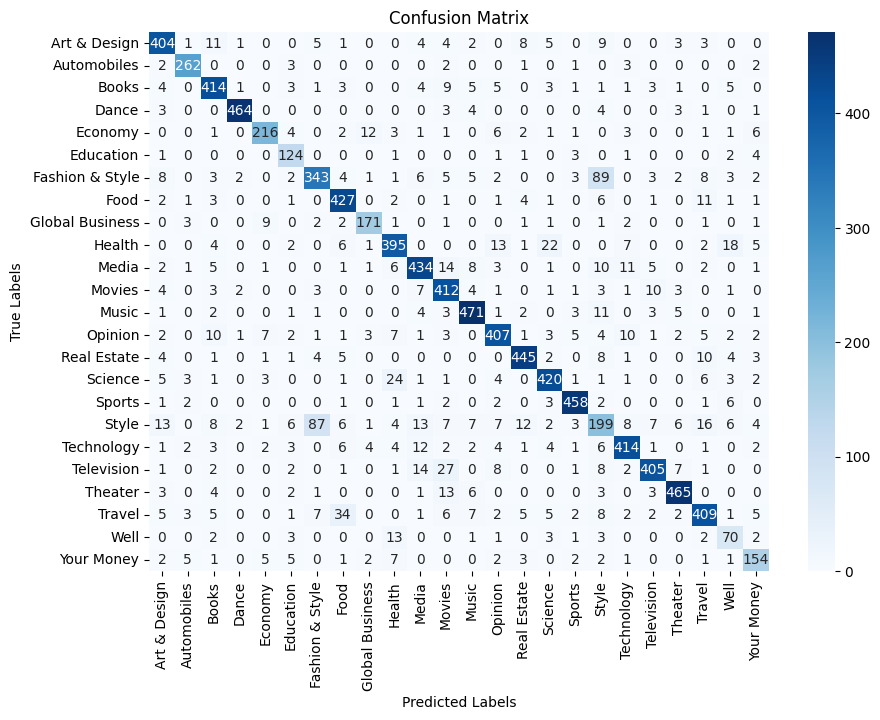

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Compute the confusion matrix using original labels
conf_mat = confusion_matrix(true_labels, pred_labels)

# Plotting the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                 xticklabels=label_encoder.classes_,
                 yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=90)
plt.show()

- The confusion matrix shows which categories are correctly predicted (high numbers on the diagonal) and which are often confused (numbers off the diagonal). Categories like "Books" and "Theater" have many correct predictions, while "Fashion & Style" is sometimes mixed up with "Style," indicating some categories are more challenging for the model to distinguish.

---
---
---

# Fine-Tuning BERT Freeze the Entire Architecture

In [18]:
# Standard library imports for array and data manipulation
import numpy as np
import pandas as pd

# PyTorch imports for building and training neural network models
import torch
import torch.nn as nn

# Scikit-learn imports for data splitting and model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Hugging Face Transformers imports for pre-trained models and utilities
import transformers
from transformers import (
    AutoModel,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    BertTokenizerFast,
    AdamW,
    get_linear_schedule_with_warmup
)


In [19]:
json_train_data.head(2)

section                                           headline  \
0     Theater  Before 'Moonlight' and 'The Walking Dead,' a F...   
1  Television  What's on TV Wednesday: 'Crip Camp' and 'Dark ...   

                                         article_url  \
0  https://www.nytimes.com/2017/02/21/theater/dan...   
1  https://www.nytimes.com/2020/03/25/arts/televi...   

                                             article  \
0  Danai Gurira and Andre Holland in a theater at...   
1  CRIP CAMP: A DISABILITY REVOLUTION (2020) Stre...   

                                            abstract  \
0  André Holland first saw Danai Gurira at New Yo...   
1  The documentary "Crip Camp: A Disability Revol...   

                             article_id  \
0  952a8b15-63f6-5e41-8f23-82dfbb33d1fa   
1  67b1b62f-43ea-59d0-bf93-a94c11845820   

                                               image  \
0  https://static01.nyt.com/images/2017/02/22/art...   
1  https://static01.nyt.com/images/2020/03/25/art...   

                                             caption  \
0  Danai Gurira and André Holland in a theater at...   
1  Judy Heumann in &ldquo;Crip Camp: A Disability...   

                               image_id  
0  952a8b15-63f6-5e41-8f23-82dfbb33d1fa  
1  67b1b62f-43ea-59d0-bf93-a94c11845820

In [20]:
json_test_data.head(2)

section                                           headline  \
0  Travel  Afropunk, Huichica and More: 8 Music Festivals...   
1   Style                  The Repurposing of a Vogue Editor   

                                         article_url  \
0  https://www.nytimes.com/2019/03/15/travel/afro...   
1  https://www.nytimes.com/2019/04/09/style/tonne...   

                                             article  \
0  An act at the FORM festival, held at Arcosanti...   
1  Tonne Goodman has a mantra for when things sta...   

                                            abstract  \
0  Whether in the desert, the forest or a city, a...   
1  After almost 20 years at the magazine, Tonne G...   

                             article_id  \
0  f756b8fa-24fb-587d-90ec-8eb834907433   
1  78a707f0-ceef-53c1-9ab3-0de5c5322fea   

                                               image  \
0  https://static01.nyt.com/images/2019/03/17/tra...   
1  https://static01.nyt.com/images/2019/04/11/fas...   

                                             caption  \
0                                    Anthony Pidgeon   
1  Ms. Goodman styled Amber Valletta with wings f...   

                               image_id  
0  f756b8fa-24fb-587d-90ec-8eb834907433  
1  78a707f0-ceef-53c1-9ab3-0de5c5322fea

In [21]:
# Take only 2 featuers
train_df = json_train_data[['section', 'article']]
test_df = json_test_data[['section', 'article']]

In [22]:
train_df.head(1)

section                                            article
0  Theater  Danai Gurira and Andre Holland in a theater at...

---

## Text cleaning and processing steps-

- Remove **punctuations**
- Encode the classes
---

In [23]:
# Function to clean and preprocess text
def clean_text(text):
    # Remove punctuation and numbers
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    # Convert text to lowercase
    text = text.lower()
    return text

In [24]:
train_df['article'] = train_df['article'].apply(clean_text)
test_df['article'] = test_df['article'].apply(clean_text)

<ipython-input-24-b43d1ee0699d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['article'] = train_df['article'].apply(clean_text)
<ipython-input-24-b43d1ee0699d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['article'] = test_df['article'].apply(clean_text)


In [25]:
# Encode the labels
label_encoder = LabelEncoder()
train_df['section'] = label_encoder.fit_transform(train_df['section'])
test_df['section'] = label_encoder.fit_transform(test_df['section'])

<ipython-input-25-8ea790ba203f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['section'] = label_encoder.fit_transform(train_df['section'])
<ipython-input-25-8ea790ba203f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['section'] = label_encoder.fit_transform(test_df['section'])


In [26]:
# Getting the mapping from encoded labels to original labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'Art & Design': 0, 'Automobiles': 1, 'Books': 2, 'Dance': 3, 'Economy': 4, 'Education': 5, 'Fashion & Style': 6, 'Food': 7, 'Global Business': 8, 'Health': 9, 'Media': 10, 'Movies': 11, 'Music': 12, 'Opinion': 13, 'Real Estate': 14, 'Science': 15, 'Sports': 16, 'Style': 17, 'Technology': 18, 'Television': 19, 'Theater': 20, 'Travel': 21, 'Well': 22, 'Your Money': 23}


 | Section | Encoded Label |
|---|---|
| Art & Design | 0 |
| Automobiles | 1 |
| Books | 2 |
| Dance | 3 |
| Economy | 4 |
| Education | 5 |
| Fashion & Style | 6 |
| Food | 7 |
| Global Business | 8 |
| Health | 9 |
| Media | 10 |
| Movies | 11 |
| Music | 12 |
| Opinion | 13 |
| Real Estate | 14 |
| Science | 15 |
| Sports | 16 |
| Style | 17 |
| Technology | 18 |
| Television | 19 |
| Theater | 20 |
| Travel | 21 |
| Well | 22 |
| Your Money | 23 |


In [27]:
train_df.head(3)

section                                            article
0       20  danai gurira and andre holland in a theater at...
1       19  crip camp a disability revolution  stream on n...
2       16  the tampa bay rays told charlie morton it woul...

In [28]:
test_df.head(3)

section                                            article
0       21  an act at the form festival held at arcosanti ...
1       17  tonne goodman has a mantra for when things sta...
2       14  the dayton area has more than a dozen sites fo...

In [29]:
from sklearn.model_selection import train_test_split

# split the train dataset into train and validation sets
train_text, val_text, train_labels, val_labels = train_test_split(
    train_df['article'], train_df['section'],
    random_state=2018,
    test_size=0.3,  # Adjust this to change the proportion allocated to the validation set
    stratify=train_df['section']
)

test_text, test_label = test_df['article'], test_df['section']


## Load BERT Model & Feature Extraction

In [30]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# sample text
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102, 0], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


## BERT Tokenization Output

- **Input IDs**:
  - Sequences of numbers where each number represents a unique token as per BERT's vocabulary.
  - Special tokens like `[CLS] = 101` (start of sequence) and `[SEP] = 102` (end of sequence) are added.
  - Padding is used to ensure sequences are of equal length, represented by `0`.

- **Token Type IDs**:
  - All values are `0`, indicating no distinction is being made between different sentences within the input.

- **Attention Mask**:
  - Indicates which tokens should be considered by the model (`1`) and which are padding (`0`) and should be ignored.

In [31]:
bert

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [32]:
# Tokenize and encode sequences in the training set.
# Converts text data into format suitable for training, adding special tokens and padding/truncating to a uniform sequence length.
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    add_special_tokens=True,      # Adds [CLS] at the start and [SEP] at the end of each sequence as required by BERT
    max_length=512,              # Maximum sequence length to which all sequences will be padded or truncated
    padding='max_length',        # Ensures all sequences are padded to the same length (updates the deprecated pad_to_max_length)
    truncation=True,             # Truncate sequences exceeding the max_length
    return_tensors='pt'          # Return PyTorch tensors
)

# Tokenize and encode sequences in the validation set similar to the training set.
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)

# Tokenize and encode sequences in the test set similar to the training and validation sets.
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    add_special_tokens=True,
    max_length=512,
    padding='max_length',
    truncation=True,
    return_tensors='pt'
)


In [33]:
## Convert the training dataset input IDs and attention masks from the tokenized data into PyTorch tensors.
train_seq = torch.tensor(tokens_train['input_ids'])  # Convert input IDs for training data to tensors for model input.
train_mask = torch.tensor(tokens_train['attention_mask'])  # Convert attention masks for training data to tensors to manage sequence padding.
train_y = torch.tensor(train_labels.tolist())  # Convert training labels to tensors for use in loss calculation.

## Convert the validation dataset input IDs and attention masks from the tokenized data into PyTorch tensors.
val_seq = torch.tensor(tokens_val['input_ids'])  # Convert input IDs for validation data to tensors for model input.
val_mask = torch.tensor(tokens_val['attention_mask'])  # Convert attention masks for validation data to tensors to manage sequence padding.
val_y = torch.tensor(val_labels.tolist())  # Convert validation labels to tensors for use in loss calculation.

## Convert the test dataset input IDs and attention masks from the tokenized data into PyTorch tensors.
test_seq = torch.tensor(tokens_test['input_ids'])  # Convert input IDs for test data to tensors for model input.
test_mask = torch.tensor(tokens_test['attention_mask'])  # Convert attention masks for test data to tensors to manage sequence padding.
test_y = torch.tensor(test_label.tolist())  # Convert test labels to tensors for use in evaluation.


<ipython-input-33-c30c01a4d452>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_seq = torch.tensor(tokens_train['input_ids'])  # Convert input IDs for training data to tensors for model input.
<ipython-input-33-c30c01a4d452>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_mask = torch.tensor(tokens_train['attention_mask'])  # Convert attention masks for training data to tensors to manage sequence padding.
<ipython-input-33-c30c01a4d452>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_seq = torch.tensor(tokens_val['input

In [34]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)


test_sampler = SequentialSampler(test_data)

# dataLoader for test set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

---

## Different Fine-Tuning Techniques

#### Train the Entire Architecture
- **Description**: The entire pre-trained model is trained further on our dataset, with the output fed into a softmax layer. The error from the output is back-propagated through the entire architecture, updating the pre-trained weights based on the new dataset.

#### Train Some Layers While Freezing Others
- **Description**: This approach involves partial training of the pre-trained model. By keeping the weights of the initial layers frozen and only retraining the higher layers, we can optimize the adaptation to our specific tasks. It's possible to experiment with the number of layers frozen and trained to find the best configuration.

#### Freeze the Entire Architecture
- **Description**: In this technique, all the layers of the model are frozen, and several new neural network layers are attached. Only the weights of these newly attached layers are updated during the training process. This method is particularly useful when we want to leverage the learned features of the pre-trained model without altering them.

---

### Fine-Tuning Technique Used: Freeze the Entire Architecture

- **Implementation**: All parameters of the BERT model (`bert`) are frozen, which means their gradients are not computed, and hence, they do not update during training (`param.requires_grad = False` for all parameters).
  
- **Custom Layers**: After freezing the BERT model, new layers are added (`fc1` and `fc2`), which are fully trainable. These layers are designed to adapt the high-level features extracted by BERT to the specific classification task (determined by `num_classes`).

- **Why**: This approach is chosen to leverage the robust, pre-trained features of BERT without the risk of overfitting smaller datasets. By freezing the original BERT layers, the model can efficiently use these features while focusing the learning on the new, smaller set of parameters that directly influence the output.

---

In [35]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

import torch.nn as nn

class BERT_Arch(nn.Module):

    def __init__(self, bert, num_classes):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 512)

        # dense layer 2 (Output layer)
        # Adapt the output layer to the number of classes
        self.fc2 = nn.Linear(512, num_classes)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    # define the forward pass
    def forward(self, sent_id, mask):
        # pass the inputs to the model
        outputs = self.bert(sent_id, attention_mask=mask)

        # Get the pooled output
        cls_hs = outputs.pooler_output

        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)

        return x

In [36]:
# Number of classes in the dataset
num_classes = 24

# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert, num_classes)

# push the model to GPU
model = model.to(device)

In [37]:
model

BERT_Arch(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Ensure train_labels is the correct variable containing all your training labels
train_labels_array = np.array(train_labels)

# Now, calculate unique_classes and class_weights in one go to avoid any changes in between.
unique_classes = np.unique(train_labels_array)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=train_labels_array
)

# Create a dictionary mapping each unique class label to its corresponding weight.
class_weight_dict = {unique_classes[i]: class_weights[i] for i in range(len(unique_classes))}

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.8394780650215433, 1: 1.4021508014393196, 2: 0.846440560821485, 3: 0.8627969001610306, 4: 1.4594399046646238, 5: 3.039982269503546, 6: 0.8560764929099262, 7: 0.855563872255489, 8: 2.1357125062282014, 9: 0.8474446421510479, 10: 0.8638401854091092, 11: 0.8560764929099262, 12: 0.8449388921742559, 13: 0.8375097694411879, 14: 0.8459394118807974, 15: 0.8550518651506084, 16: 0.8479475766567754, 17: 0.9506265247283211, 18: 0.8591651633593906, 19: 0.8439407363654262, 20: 0.8474446421510479, 21: 0.8459394118807974, 22: 3.861599099099099, 23: 2.001108776844071}


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

In [ ]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
import datetime
import time

def format_time(elapsed):
    """
    Takes a time in seconds and returns a string hh:mm:ss
    """
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


# function for evaluating the model
def evaluate():
    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []

    # Start time for measuring the whole evaluation duration
    t0 = time.time()

    # iterate over batches
    for step, batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Elapsed: {:}.'.format(step, len(val_dataloader), elapsed))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds, labels)

            total_loss += loss.item()

            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


## Train the Model

In [ ]:
import torch
from tqdm.notebook import tqdm

# Set initial loss to infinity
best_valid_loss = float('inf')

# Number of epochs and early stopping criteria
epochs = 10
patience = 5
epochs_no_improve = 0

# Empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# For each epoch with tqdm progress bar
for epoch in tqdm(range(epochs), desc='Epochs', unit='epoch'):

    # Print epoch (tqdm also shows progress, so this could be optional)
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    # Train model and get loss
    train_loss, _ = train()

    # Evaluate model and get validation loss
    valid_loss, _ = evaluate()

    # Save the best model if validation loss decreases
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/ColabNotebooks/nlp_project/level_1/saved_weights.pt')
        print("Validation loss decreased ({:.3f} --> {:.3f}). Saving model ...".format(best_valid_loss, valid_loss))
        epochs_no_improve = 0  # Reset counter
    else:
        epochs_no_improve += 1
        print("No improvement in validation loss for {} epochs.".format(epochs_no_improve))

    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Print training and validation loss
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    # Early stopping check
    if epochs_no_improve == patience:
        print("Early stopping triggered after {} epochs without improvement.".format(patience))
        break


Epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]


 Epoch 1 / 10
  Batch    50  of  1,072.
  Batch   100  of  1,072.
  Batch   150  of  1,072.
  Batch   200  of  1,072.
  Batch   250  of  1,072.
  Batch   300  of  1,072.
  Batch   350  of  1,072.
  Batch   400  of  1,072.
  Batch   450  of  1,072.
  Batch   500  of  1,072.
  Batch   550  of  1,072.
  Batch   600  of  1,072.
  Batch   650  of  1,072.
  Batch   700  of  1,072.
  Batch   750  of  1,072.
  Batch   800  of  1,072.
  Batch   850  of  1,072.
  Batch   900  of  1,072.
  Batch   950  of  1,072.
  Batch 1,000  of  1,072.
  Batch 1,050  of  1,072.

Evaluating...
  Batch    50  of    460. Elapsed: 0:00:30.
  Batch   100  of    460. Elapsed: 0:00:59.
  Batch   150  of    460. Elapsed: 0:01:29.
  Batch   200  of    460. Elapsed: 0:01:58.
  Batch   250  of    460. Elapsed: 0:02:28.
  Batch   300  of    460. Elapsed: 0:02:58.
  Batch   350  of    460. Elapsed: 0:03:27.
  Batch   400  of    460. Elapsed: 0:03:57.
  Batch   450  of    460. Elapsed: 0:04:26.
Validation loss decreased (3

## Load the Machen Learning Model

In [38]:
#load weights of best model
path = '/content/drive/MyDrive/ColabNotebooks/nlp_project/level_1/saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

## Evaluate the Model

In [43]:
# List to store all predictions
all_preds = []

# Disable gradient calculation to save memory and computations, since gradients are not needed for inference
with torch.no_grad():
    # Iterate over test data batches
    for batch in test_dataloader:
        # Unpack the batch data and transfer tensors to the computation device (e.g., GPU)
        test_seq, test_mask, _ = [t.to(device) for t in batch]  # Labels are not needed for prediction, hence ignored

        # Generate predictions using the model
        outputs = model(test_seq, test_mask)

        # Convert model outputs (logits) to probabilities or class scores and move to CPU
        preds = outputs.detach().cpu().numpy()
        # Store predictions from the current batch
        all_preds.append(preds)

# Concatenate all batch predictions into a single numpy array for overall prediction results
preds = np.concatenate(all_preds, axis=0)

# Convert logits to actual class predictions based on the highest probability
preds = np.argmax(preds, axis=1)

# Ensure test_y is also transformed back to original categorical labels if it is not already
test_y_labels = label_encoder.inverse_transform(test_y)

# Use the label encoder to transform numerical predictions back to original categorical labels
preds_labels = label_encoder.inverse_transform(preds)

# Generate a classification report that includes precision, recall, and f1-score using the original labels
print(classification_report(test_y_labels, preds_labels))



                 precision    recall  f1-score   support

   Art & Design       0.42      0.56      0.48       313
    Automobiles       0.44      0.55      0.49       173
          Books       0.44      0.71      0.55       305
          Dance       0.75      0.47      0.57       318
        Economy       0.42      0.20      0.27       183
      Education       0.00      0.00      0.00        74
Fashion & Style       0.48      0.26      0.34       307
           Food       0.66      0.44      0.53       290
Global Business       0.26      0.67      0.38       100
         Health       0.32      0.68      0.43       307
          Media       0.58      0.17      0.26       326
         Movies       0.53      0.37      0.43       292
          Music       0.46      0.41      0.43       286
        Opinion       0.37      0.19      0.25       284
    Real Estate       0.43      0.36      0.39       299
        Science       0.47      0.42      0.44       306
         Sports       0.48    

# Classification Report Observations

The classification report provides the precision, recall, f1-score, and support for various categories:

- **High Performance**:
  - **Dance** show a high precision and recall, leading to the highest f1-score of 0.75.
  - **Books** and **Dance** also demonstrate strong overall performance with f1-scores of 0.55 and 0.57 respectively.

- **Moderate Performance**:
  - **Art & Design**, **Automobiles**, and **Global Business** have moderate f1-scores around 0.48, 0.49, and 0.43 respectively, indicating a balanced but average precision and recall.

- **Poor Performance**:
  - **Education** and **Well** have particularly low scores across all metrics with f1-scores of 0.00 and 0.08 respectively, suggesting difficulties in accurately predicting these categories.
  - **Your Money** has the lowest precision at 0.12, significantly impacting its f1-score of 0.19.

  
- **Overall Accuracy**:
  - The overall accuracy of the model is 0.41, which suggests that the model correctly predicts the label 41% of the time across all categories.
  - The macro average and weighted average scores for precision, recall, and f1-score are around 0.41, 0.39, and 0.37 respectively, indicating room for improvement in model performance.



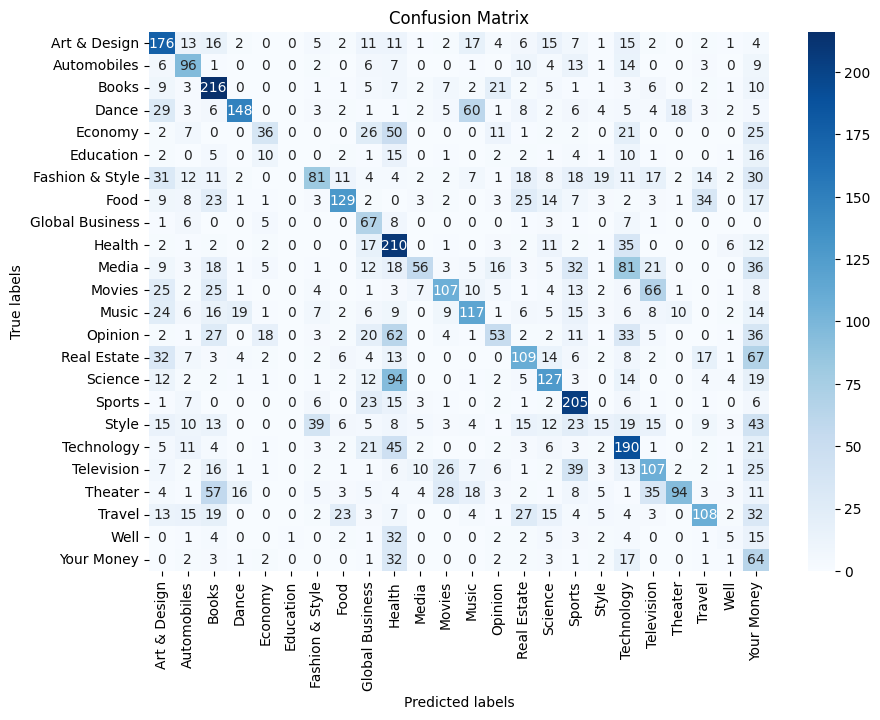

In [45]:
# Calculate the confusion matrix from true labels and predictions
conf_matrix = confusion_matrix(test_y_labels, preds_labels)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                 xticklabels=label_encoder.classes_,
                 yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Fine-Tuning BERT Train the Entire Architecture

In [8]:
train_df = json_train_data[['section', 'article']]
test_df = json_test_data[['section', 'article']]

In [9]:
train_df.head(1)

section                                            article
0  Theater  Danai Gurira and Andre Holland in a theater at...

In [10]:
# Encode the labels
label_encoder = LabelEncoder()
train_df['section'] = label_encoder.fit_transform(train_df['section'])
test_df['section'] = label_encoder.fit_transform(test_df['section'])

<ipython-input-10-8ea790ba203f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['section'] = label_encoder.fit_transform(train_df['section'])
<ipython-input-10-8ea790ba203f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['section'] = label_encoder.fit_transform(test_df['section'])


In [11]:
import joblib

# Specify the path where you want to save the LabelEncoder
path = '/content/drive/MyDrive/ColabNotebooks/nlp_project/level_1/label_encoder.pkl'

# Save the fitted LabelEncoder to disk
joblib.dump(label_encoder, path)

['/content/drive/MyDrive/ColabNotebooks/nlp_project/level_1/label_encoder.pkl']

In [ ]:
from sklearn.model_selection import train_test_split

# split the train dataset into train and validation sets
train_text, val_text, train_labels, val_labels = train_test_split(
    train_df['article'], train_df['section'],
    random_state=2018,
    test_size=0.3,  # Adjust this to change the proportion allocated to the validation set
    stratify=train_df['section']
)

test_text, test_label = test_df['article'], test_df['section']


In [ ]:
# Load multi-class bert model
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=24)

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# push the model to GPU
model = model.to(device)
model

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    add_special_tokens=True,
    max_length = 512,
    pad_to_max_length=True,
    truncation=True,
    return_tensors='pt'
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    add_special_tokens=True,
    max_length = 512,
    pad_to_max_length=True,
    truncation=True,
    return_tensors='pt'
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    add_special_tokens=True,
    max_length = 512,
    pad_to_max_length=True,
    truncation=True,
    return_tensors='pt'
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_label.tolist())

<ipython-input-18-360ef1d90611>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_seq = torch.tensor(tokens_train['input_ids'])
<ipython-input-18-360ef1d90611>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_mask = torch.tensor(tokens_train['attention_mask'])
<ipython-input-18-360ef1d90611>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_seq = torch.tensor(tokens_val['input_ids'])
<ipython-input-18-360ef1d90611>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sour

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

# wrap tensors
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

# dataLoader for test set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

In [ ]:
# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Ensure train_labels is the correct variable containing all your training labels
train_labels_array = np.array(train_labels)

# Now, calculate unique_classes and class_weights in one go to avoid any changes in between.
unique_classes = np.unique(train_labels_array)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=train_labels_array
)

# Create a dictionary mapping each unique class label to its corresponding weight.
class_weight_dict = {unique_classes[i]: class_weights[i] for i in range(len(unique_classes))}

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.8394780650215433, 1: 1.4021508014393196, 2: 0.846440560821485, 3: 0.8627969001610306, 4: 1.4594399046646238, 5: 3.039982269503546, 6: 0.8560764929099262, 7: 0.855563872255489, 8: 2.1357125062282014, 9: 0.8474446421510479, 10: 0.8638401854091092, 11: 0.8560764929099262, 12: 0.8449388921742559, 13: 0.8375097694411879, 14: 0.8459394118807974, 15: 0.8550518651506084, 16: 0.8479475766567754, 17: 0.9506265247283211, 18: 0.8591651633593906, 19: 0.8439407363654262, 20: 0.8474446421510479, 21: 0.8459394118807974, 22: 3.861599099099099, 23: 2.001108776844071}


In [ ]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 50

In [ ]:
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    for step, batch in enumerate(tqdm(train_dataloader, desc="Training")):
        if step % 50 == 0 and not step == 0:
            print('Batch {:>5,} of {:>5,}.'.format(step, len(train_dataloader)))

        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        model.zero_grad()
        outputs = model(input_ids=sent_id, attention_mask=mask, labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        logits = outputs.logits.detach().cpu().numpy()
        total_preds.append(logits)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


In [ ]:
import datetime
import time

def format_time(elapsed):
    """
    Takes a time in seconds and returns a string hh:mm:ss
    """
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def evaluate():
    print("\nEvaluating...")
    model.eval()
    total_loss, total_accuracy = 0, 0
    total_preds = []

    t0 = time.time()
    for step, batch in enumerate(tqdm(val_dataloader, desc="Training")):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('Batch {:>5,} of {:>5,}. Elapsed: {:}.'.format(step, len(val_dataloader), elapsed))

        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids=sent_id, attention_mask=mask, labels=labels)

        loss = outputs.loss
        total_loss += loss.item()

        preds = outputs.logits.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds

In [ ]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        """
        Args:
            patience (int): How many epochs to wait after last time validation loss improved.
                            Default: 7
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                               Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                print("Early stopping")
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

## Train the Model

In [ ]:
import copy
import torch
from tqdm.notebook import tqdm

# Set initial loss to infinity
best_valid_loss = float('inf')

# Number of epochs and early stopping criteria
epochs = 10
early_stopping = EarlyStopping(patience=5)
epochs_no_improve = 0

# Empty lists to store training and validation loss of each epoch
train_losses = []
valid_losses = []

# For each epoch with tqdm progress bar
for epoch in tqdm(range(epochs), desc='Epochs', unit='epoch'):
    start_time = time.time()


    # Print epoch (tqdm also shows progress, so this could be optional)
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    # Train model and get loss
    train_loss, _ = train()

    # Evaluate model and get validation loss
    valid_loss, _ = evaluate()


    # Append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

        # Check early stopping
    early_stopping(valid_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

    # Log the epoch details
    end_time = time.time()
    epoch_time = end_time - start_time
   # Save the best model
    if valid_loss == min(valid_losses):
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(best_model_wts, ('/content/drive/MyDrive/ColabNotebooks/nlp_project/level_1/fine-tune_bert_all_parameters.pt'))


    # Print training and validation loss
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')

    print(f"Epoch {epoch+1}/{epochs}, Time: {epoch_time:.2f}s, Loss: {train_loss:.4f}, Val Loss: {valid_loss:.4f}")


Epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]


 Epoch 1 / 10


Training:   0%|          | 0/1072 [00:00<?, ?it/s]

Batch    50 of 1,072.
Batch   100 of 1,072.
Batch   150 of 1,072.
Batch   200 of 1,072.
Batch   250 of 1,072.
Batch   300 of 1,072.
Batch   350 of 1,072.
Batch   400 of 1,072.
Batch   450 of 1,072.
Batch   500 of 1,072.
Batch   550 of 1,072.
Batch   600 of 1,072.
Batch   650 of 1,072.
Batch   700 of 1,072.
Batch   750 of 1,072.
Batch   800 of 1,072.
Batch   850 of 1,072.
Batch   900 of 1,072.
Batch   950 of 1,072.
Batch 1,000 of 1,072.
Batch 1,050 of 1,072.

Evaluating...


Training:   0%|          | 0/460 [00:00<?, ?it/s]

Batch    50 of   460. Elapsed: 0:00:29.
Batch   100 of   460. Elapsed: 0:00:59.
Batch   150 of   460. Elapsed: 0:01:28.
Batch   200 of   460. Elapsed: 0:01:57.
Batch   250 of   460. Elapsed: 0:02:27.
Batch   300 of   460. Elapsed: 0:02:56.
Batch   350 of   460. Elapsed: 0:03:25.
Batch   400 of   460. Elapsed: 0:03:54.
Batch   450 of   460. Elapsed: 0:04:24.

Training Loss: 1.211
Validation Loss: 0.587
Epoch 1/10, Time: 1971.54s, Loss: 1.2109, Val Loss: 0.5870

 Epoch 2 / 10


Training:   0%|          | 0/1072 [00:00<?, ?it/s]

Batch    50 of 1,072.
Batch   100 of 1,072.
Batch   150 of 1,072.
Batch   200 of 1,072.
Batch   250 of 1,072.
Batch   300 of 1,072.
Batch   350 of 1,072.
Batch   400 of 1,072.
Batch   450 of 1,072.
Batch   500 of 1,072.
Batch   550 of 1,072.
Batch   600 of 1,072.
Batch   650 of 1,072.
Batch   700 of 1,072.
Batch   750 of 1,072.
Batch   800 of 1,072.
Batch   850 of 1,072.
Batch   900 of 1,072.
Batch   950 of 1,072.
Batch 1,000 of 1,072.
Batch 1,050 of 1,072.

Evaluating...


Training:   0%|          | 0/460 [00:00<?, ?it/s]

Batch    50 of   460. Elapsed: 0:00:29.
Batch   100 of   460. Elapsed: 0:00:59.
Batch   150 of   460. Elapsed: 0:01:28.
Batch   200 of   460. Elapsed: 0:01:57.
Batch   250 of   460. Elapsed: 0:02:26.
Batch   300 of   460. Elapsed: 0:02:56.
Batch   350 of   460. Elapsed: 0:03:25.
Batch   400 of   460. Elapsed: 0:03:54.
Batch   450 of   460. Elapsed: 0:04:23.

Training Loss: 0.480
Validation Loss: 0.463
Epoch 2/10, Time: 1970.50s, Loss: 0.4796, Val Loss: 0.4626

 Epoch 3 / 10


Training:   0%|          | 0/1072 [00:00<?, ?it/s]

Batch    50 of 1,072.
Batch   100 of 1,072.
Batch   150 of 1,072.
Batch   200 of 1,072.
Batch   250 of 1,072.
Batch   300 of 1,072.
Batch   350 of 1,072.
Batch   400 of 1,072.
Batch   450 of 1,072.
Batch   500 of 1,072.
Batch   550 of 1,072.
Batch   600 of 1,072.
Batch   650 of 1,072.
Batch   700 of 1,072.
Batch   750 of 1,072.
Batch   800 of 1,072.
Batch   850 of 1,072.
Batch   900 of 1,072.
Batch   950 of 1,072.
Batch 1,000 of 1,072.
Batch 1,050 of 1,072.

Evaluating...


Training:   0%|          | 0/460 [00:00<?, ?it/s]

Batch    50 of   460. Elapsed: 0:00:29.
Batch   100 of   460. Elapsed: 0:00:59.
Batch   150 of   460. Elapsed: 0:01:28.
Batch   200 of   460. Elapsed: 0:01:57.
Batch   250 of   460. Elapsed: 0:02:26.
Batch   300 of   460. Elapsed: 0:02:56.
Batch   350 of   460. Elapsed: 0:03:25.
Batch   400 of   460. Elapsed: 0:03:54.
Batch   450 of   460. Elapsed: 0:04:23.

Training Loss: 0.330
Validation Loss: 0.434
Epoch 3/10, Time: 1974.22s, Loss: 0.3302, Val Loss: 0.4338

 Epoch 4 / 10


Training:   0%|          | 0/1072 [00:00<?, ?it/s]

Batch    50 of 1,072.
Batch   100 of 1,072.
Batch   150 of 1,072.
Batch   200 of 1,072.
Batch   250 of 1,072.
Batch   300 of 1,072.
Batch   350 of 1,072.
Batch   400 of 1,072.
Batch   450 of 1,072.
Batch   500 of 1,072.
Batch   550 of 1,072.
Batch   600 of 1,072.
Batch   650 of 1,072.
Batch   700 of 1,072.
Batch   750 of 1,072.
Batch   800 of 1,072.
Batch   850 of 1,072.
Batch   900 of 1,072.
Batch   950 of 1,072.
Batch 1,000 of 1,072.
Batch 1,050 of 1,072.

Evaluating...


Training:   0%|          | 0/460 [00:00<?, ?it/s]

Batch    50 of   460. Elapsed: 0:00:29.
Batch   100 of   460. Elapsed: 0:00:59.
Batch   150 of   460. Elapsed: 0:01:28.
Batch   200 of   460. Elapsed: 0:01:57.
Batch   250 of   460. Elapsed: 0:02:27.
Batch   300 of   460. Elapsed: 0:02:56.
Batch   350 of   460. Elapsed: 0:03:25.
Batch   400 of   460. Elapsed: 0:03:54.
Batch   450 of   460. Elapsed: 0:04:24.
EarlyStopping counter: 1 out of 5

Training Loss: 0.239
Validation Loss: 0.468
Epoch 4/10, Time: 1974.66s, Loss: 0.2393, Val Loss: 0.4680

 Epoch 5 / 10


Training:   0%|          | 0/1072 [00:00<?, ?it/s]

Batch    50 of 1,072.
Batch   100 of 1,072.
Batch   150 of 1,072.
Batch   200 of 1,072.
Batch   250 of 1,072.
Batch   300 of 1,072.
Batch   350 of 1,072.
Batch   400 of 1,072.
Batch   450 of 1,072.
Batch   500 of 1,072.
Batch   550 of 1,072.
Batch   600 of 1,072.
Batch   650 of 1,072.
Batch   700 of 1,072.
Batch   750 of 1,072.
Batch   800 of 1,072.
Batch   850 of 1,072.
Batch   900 of 1,072.
Batch   950 of 1,072.
Batch 1,000 of 1,072.
Batch 1,050 of 1,072.

Evaluating...


Training:   0%|          | 0/460 [00:00<?, ?it/s]

Batch    50 of   460. Elapsed: 0:00:29.
Batch   100 of   460. Elapsed: 0:00:59.
Batch   150 of   460. Elapsed: 0:01:28.
Batch   200 of   460. Elapsed: 0:01:57.
Batch   250 of   460. Elapsed: 0:02:26.
Batch   300 of   460. Elapsed: 0:02:56.
Batch   350 of   460. Elapsed: 0:03:25.
Batch   400 of   460. Elapsed: 0:03:54.
Batch   450 of   460. Elapsed: 0:04:24.
EarlyStopping counter: 2 out of 5

Training Loss: 0.175
Validation Loss: 0.492
Epoch 5/10, Time: 1974.83s, Loss: 0.1745, Val Loss: 0.4918

 Epoch 6 / 10


Training:   0%|          | 0/1072 [00:00<?, ?it/s]

Batch    50 of 1,072.
Batch   100 of 1,072.
Batch   150 of 1,072.
Batch   200 of 1,072.
Batch   250 of 1,072.
Batch   300 of 1,072.
Batch   350 of 1,072.
Batch   400 of 1,072.
Batch   450 of 1,072.
Batch   500 of 1,072.
Batch   550 of 1,072.
Batch   600 of 1,072.
Batch   650 of 1,072.
Batch   700 of 1,072.
Batch   750 of 1,072.
Batch   800 of 1,072.
Batch   850 of 1,072.
Batch   900 of 1,072.
Batch   950 of 1,072.
Batch 1,000 of 1,072.
Batch 1,050 of 1,072.

Evaluating...


Training:   0%|          | 0/460 [00:00<?, ?it/s]

Batch    50 of   460. Elapsed: 0:00:29.
Batch   100 of   460. Elapsed: 0:00:59.
Batch   150 of   460. Elapsed: 0:01:28.
Batch   200 of   460. Elapsed: 0:01:57.
Batch   250 of   460. Elapsed: 0:02:26.
Batch   300 of   460. Elapsed: 0:02:56.
Batch   350 of   460. Elapsed: 0:03:25.
Batch   400 of   460. Elapsed: 0:03:54.
Batch   450 of   460. Elapsed: 0:04:24.
EarlyStopping counter: 3 out of 5

Training Loss: 0.124
Validation Loss: 0.530
Epoch 6/10, Time: 1974.55s, Loss: 0.1243, Val Loss: 0.5304

 Epoch 7 / 10


Training:   0%|          | 0/1072 [00:00<?, ?it/s]

Batch    50 of 1,072.
Batch   100 of 1,072.
Batch   150 of 1,072.
Batch   200 of 1,072.
Batch   250 of 1,072.
Batch   300 of 1,072.
Batch   350 of 1,072.
Batch   400 of 1,072.
Batch   450 of 1,072.
Batch   500 of 1,072.
Batch   550 of 1,072.
Batch   600 of 1,072.
Batch   650 of 1,072.
Batch   700 of 1,072.
Batch   750 of 1,072.
Batch   800 of 1,072.
Batch   850 of 1,072.
Batch   900 of 1,072.
Batch   950 of 1,072.
Batch 1,000 of 1,072.
Batch 1,050 of 1,072.

Evaluating...


Training:   0%|          | 0/460 [00:00<?, ?it/s]

Batch    50 of   460. Elapsed: 0:00:29.
Batch   100 of   460. Elapsed: 0:00:59.
Batch   150 of   460. Elapsed: 0:01:28.
Batch   200 of   460. Elapsed: 0:01:57.
Batch   250 of   460. Elapsed: 0:02:26.
Batch   300 of   460. Elapsed: 0:02:56.
Batch   350 of   460. Elapsed: 0:03:25.
Batch   400 of   460. Elapsed: 0:03:54.
Batch   450 of   460. Elapsed: 0:04:23.
EarlyStopping counter: 4 out of 5

Training Loss: 0.095
Validation Loss: 0.576
Epoch 7/10, Time: 1974.17s, Loss: 0.0948, Val Loss: 0.5764

 Epoch 8 / 10


Training:   0%|          | 0/1072 [00:00<?, ?it/s]

Batch    50 of 1,072.
Batch   100 of 1,072.
Batch   150 of 1,072.
Batch   200 of 1,072.
Batch   250 of 1,072.
Batch   300 of 1,072.
Batch   350 of 1,072.
Batch   400 of 1,072.
Batch   450 of 1,072.
Batch   500 of 1,072.
Batch   550 of 1,072.
Batch   600 of 1,072.
Batch   650 of 1,072.
Batch   700 of 1,072.
Batch   750 of 1,072.
Batch   800 of 1,072.
Batch   850 of 1,072.
Batch   900 of 1,072.
Batch   950 of 1,072.
Batch 1,000 of 1,072.
Batch 1,050 of 1,072.

Evaluating...


Training:   0%|          | 0/460 [00:00<?, ?it/s]

Batch    50 of   460. Elapsed: 0:00:29.
Batch   100 of   460. Elapsed: 0:00:59.
Batch   150 of   460. Elapsed: 0:01:28.
Batch   200 of   460. Elapsed: 0:01:57.
Batch   250 of   460. Elapsed: 0:02:26.
Batch   300 of   460. Elapsed: 0:02:55.
Batch   350 of   460. Elapsed: 0:03:25.
Batch   400 of   460. Elapsed: 0:03:54.
Batch   450 of   460. Elapsed: 0:04:23.
EarlyStopping counter: 5 out of 5
Early stopping
Early stopping triggered.


In [ ]:
#load weights of best model
path = '/content/drive/MyDrive/ColabNotebooks/nlp_project/level_1/fine-tune_bert_all_parameters.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
import torch
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Make sure the model is in evaluation mode
model.eval()

# Lists to store predictions and labels
all_logits = []
true_labels = []
pred_labels = []

# Disable gradient calculation
with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        # Move tensors to the appropriate device
        input_ids, attention_mask, labels = [t.to(device) for t in batch]

        # Model forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Extract logits and move them to CPU
        logits = outputs.logits.detach().cpu().numpy()
        all_logits.append(logits)

        # Get the predictions from logits
        predictions = torch.argmax(outputs.logits, dim=-1).cpu().numpy()

        # Collect true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predictions)

# Concatenate all batch logits into a single numpy array
all_logits = np.concatenate(all_logits, axis=0)

# Convert lists to numpy arrays for compatibility with sklearn
true_labels = np.array(label_encoder.inverse_transform(true_labels))
pred_labels = np.array(label_encoder.inverse_transform(pred_labels))

print("Accuracy score: {}".format(accuracy_score(true_labels, pred_labels)))

# Display classification report
print("Classification Report:")
print(classification_report(true_labels, pred_labels))

Evaluating:   0%|          | 0/192 [00:00<?, ?it/s]

Accuracy score: 0.8675702155453952
Classification Report:
                 precision    recall  f1-score   support

   Art & Design       0.88      0.90      0.89       313
    Automobiles       0.95      0.95      0.95       173
          Books       0.94      0.94      0.94       305
          Dance       0.97      0.96      0.96       318
        Economy       0.94      0.84      0.88       183
      Education       0.79      0.80      0.79        74
Fashion & Style       0.73      0.78      0.75       307
           Food       0.87      0.93      0.90       290
Global Business       0.85      0.88      0.87       100
         Health       0.74      0.93      0.83       307
          Media       0.89      0.83      0.86       326
         Movies       0.86      0.96      0.90       292
          Music       0.93      0.90      0.91       286
        Opinion       0.86      0.82      0.84       284
    Real Estate       0.93      0.92      0.92       299
        Science       0.90   

## Summary of Classification Report

- **Overall Accuracy**: The model achieves an accuracy of approximately 86.75%, indicating strong performance across most categories.

- **High Performing Categories**:
  - **Automobiles, Books, Dance, Sports**: These categories show high precision, recall, and F1-scores, indicating that the model classifies them accurately and consistently.

- **Low Performing Categories**:
  - **Fashion & Style, Well, Style**: These categories have lower performance metrics, especially "Well," which has a notably low recall of 0.29, suggesting the model often misses true instances of this category.

- **Precision and Recall**:
  - Precision across categories is generally high, meaning the model's predictions are usually correct.
  - Recall varies more, with some categories like "Well" significantly lower, indicating inconsistency in identifying all true instances.

- **Support**:
  - The number of samples per category varies, affecting the model's learning and performance, with categories having more samples showing generally better performance.

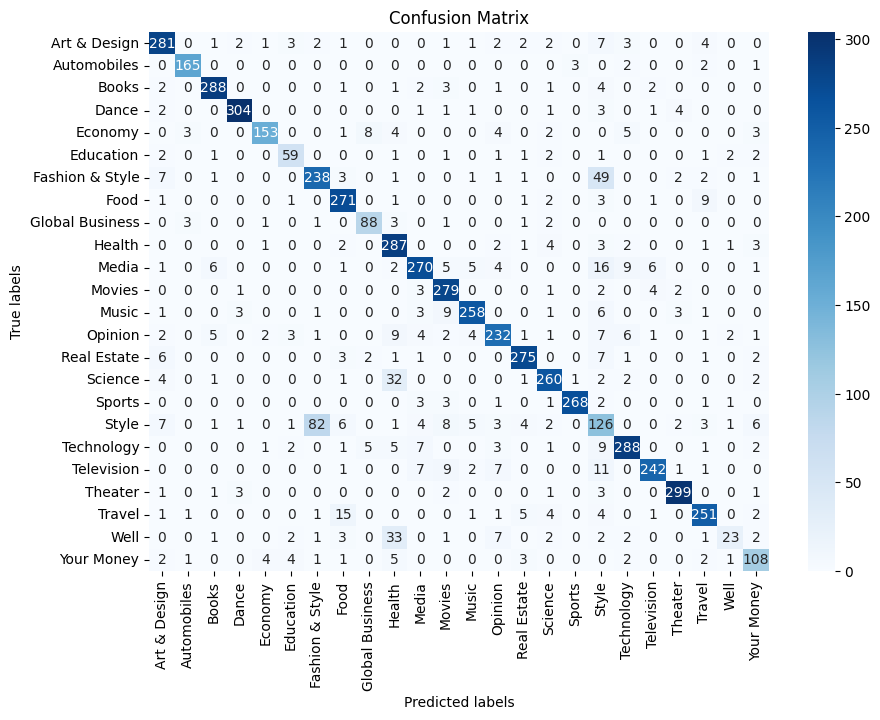

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, pred_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=label_encoder.classes_,
                 yticklabels=label_encoder.classes_)
plt.xlabel('Predicted labels')
plt.xticks(rotation=90)
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## Conf mat

- **Diagonal Dominance**: The highest numbers in each row tend to be on the diagonal, indicating that the model correctly predicts most categories. For instance, "Dance" has 304 correct predictions, and "Theater" has 299.
  
- **Misclassifications**:
  - Certain categories show notable confusion with others, suggesting similarities or misinterpretations by the model. For example:
    - "Fashion & Style" is sometimes confused with "Style".
    - "Health" has significant misclassifications with "Well, and Science ".

- **High Precision Categories**:
  - Categories such as "Technology" with 288 correct predictions out of a fewer number of misclassifications suggest high precision.

- **Categories with Concerns**:
  - "Fashion & Style" shows a considerable number of misclassifications compared to correct predictions (238 correct vs. 82 misclassified as "Style"), indicating potential issues in distinguishing closely related categories.
  - "Health" also shows a large number of misclassifications (33 instances) compared to correct predictions, which could be due to vague or overlapping features with other categories like "Well."


---
---
---

# Text Summarization Task

### Encoding

**Encoding** is the process of converting text into a format that a computer can understand. Computers don't process characters and words directly but rather deal with numbers. So, encoding transforms the text into a series of numbers (often called tokens) that represent words or parts of words. This step is crucial for preparing text data to be input into machine learning models.

### Decoding

**Decoding** is the reverse process of encoding. It converts the numerical data (tokens) back into human-readable text. After an NLP model processes the encoded data and produces output in numerical form, decoding transforms this output back into text that we can understand. This is especially important in tasks like text generation, translation, or summarization, where the final output needs to be readable text.

### Load Libraries

In [19]:
from transformers import BartTokenizer, BartForConditionalGeneration
from bert_score import score

### Load Summarization Model and Tokenization

In [14]:
level_2_train = json_train_data[['article', 'abstract']]
level_2_test = json_test_data[['article', 'abstract']]

In [15]:
# Get the article from the DataFrame
article = level_2_train['article'][4]
article = f"""{article}"""
article

'Jimmy Buffett\'s tropical paradise will land in a chilly New York this winter with the opening of the musical "Escape to Margaritaville" on Broadway.\n\nThe show, which features new songs as well as past hits that embody Mr. Buffett\'s beach-resort brand, is to begin preview performances at the Marquis Theater on Feb. 16, the producers announced on Monday, with opening night planned for March 15.\n\n"Well, going to Broadway is a dream come true, but to be coming to the Marquis is like having a great margarita with a tequila floater," Mr. Buffett said in a statement.'

In [16]:
# Get the abstract from the DataFrame
abstract = level_2_train['abstract'][4]
abstract = f"""{abstract}"""
abstract

'"Escape to Margaritaville," which features new songs and past hits by Mr. Buffett, will begin performances at the Marquis Theater in February.'

In [17]:
# Initialize tokenizer and model
tokenizer = BartTokenizer.from_pretrained('sshleifer/distilbart-cnn-12-6')
model = BartForConditionalGeneration.from_pretrained('sshleifer/distilbart-cnn-12-6')

inputs = tokenizer(article, return_tensors="pt", truncation=True, max_length=1024)
encoded_text = tokenizer.encode(article)
print("Number of tokens:", len(encoded_text))
print("Tokenized output:", encoded_text)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.80k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

Number of tokens: 135
Tokenized output: [0, 35693, 17776, 18, 10602, 26215, 40, 1212, 11, 10, 23141, 188, 469, 42, 2608, 19, 5, 1273, 9, 5, 4388, 22, 717, 18795, 7, 7572, 271, 405, 1469, 4061, 113, 15, 7099, 4, 50118, 50118, 133, 311, 6, 61, 1575, 92, 3686, 25, 157, 25, 375, 2323, 14, 33865, 427, 4, 17776, 18, 4105, 12, 1535, 2723, 1518, 6, 16, 7, 1642, 11125, 4476, 23, 5, 14803, 354, 10112, 15, 1927, 4, 545, 6, 5, 4426, 585, 15, 302, 6, 19, 1273, 363, 1904, 13, 494, 379, 4, 50118, 50118, 113, 8346, 6, 164, 7, 7099, 16, 10, 3366, 283, 1528, 6, 53, 7, 28, 567, 7, 5, 14803, 354, 16, 101, 519, 10, 372, 31417, 271, 3119, 19, 10, 3055, 27224, 27325, 5109, 60, 427, 4, 17776, 26, 11, 10, 445, 4, 2]


In [24]:
test_summer = level_2_test.sample(n=200, random_state=42)

In [ ]:
from tqdm import tqdm
def generate_summaries(articles, tokenizer, model, batch_size=10):
    summaries = []
    for i in tqdm(range(0, len(articles), batch_size)):
        batch = articles[i:i+batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=1024)
        summary_ids = model.generate(inputs['input_ids'], max_length=130, min_length=30, do_sample=False)
        batch_summaries = [tokenizer.decode(g, skip_special_tokens=True) for g in summary_ids]
        summaries.extend(batch_summaries)
    return summaries

summaries = generate_summaries(test_summer['abstract'].tolist(), tokenizer, model, batch_size=10)

- The score function returns three values: the precision (P), the coverage (R), and the F1 score. The higher the F1 score, the better the quality of the summary.

- BERTScore is able to deal with ambiguity problems of words, synonyms and antonyms, which makes it especially useful for evaluating the quality of summaries generated by Transformer models. Using the BERTScore library in Python, it’s easy to calculate the BERT score for a list of sentence pairs.

In [31]:
# Calculate BERTScore
P, R, F1 = score(summaries, test_summer['abstract'].tolist(), lang='en', verbose=True)

# Print the average BERTScores
print("Precision:", P.mean().item())
print("coverage:", R.mean().item())
print("F1 Score:", F1.mean().item())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/7 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/4 [00:00<?, ?it/s]

done in 2.63 seconds, 76.12 sentences/sec
Precision: 0.9640519022941589
coverage: 0.9743815064430237
F1 Score: 0.9690546989440918


## **Performance Metrics**
- Precision: 0.9641
  - This score indicates that, on average, the elements (words/tokens) in our generated summaries closely correspond to elements in the reference abstracts. A high precision means that most of the content in the generated summaries was relevant and found in the reference texts.
- Coverage: 0.9744
  - Coverage in the context of BERTScore indicates how well the reference abstracts are covered by the words in the generated summaries. A high coverage suggests that the summaries did an excellent job of capturing the content that is considered important or central in the reference texts.
- F1 Score: 0.9691
  - The F1 score, being the harmonic mean of precision and coverage, provides a single metric that balances both the completeness (coverage) and accuracy (precision) of the summaries against the references. An F1 score close to 1, as in this case, indicates very effective summarization, achieving both high relevance and coverage.

In [18]:
# Generate summaries
summary_ids = model.generate(inputs['input_ids'], max_length=130, min_length=30, do_sample=False)
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print(summary)
print(len(summary.split(' ')))

 "Escape to Margaritaville" is to begin preview performances at the Marquis Theater on Feb. 16. The show features new songs as well as past hits that embody Mr. Buffett's beach-resort brand.
32


## Text Summarization



1. **Tokenizer and Model Initialization**:
   - `BartTokenizer` and `BartForConditionalGeneration` are loaded with the model `'sshleifer/distilbart-cnn-12-6'` prepared for text summarization.

2. **Text Preparation**:
   - The article text is tokenized, converted to tensors, and truncated or padded to a maximum length of 1024 tokens.

3. **Generate Summary**:
   - The model generates a summary, enforcing a maximum and minimum length, without sampling for deterministic output.

4. **Decode and Display Summary**:
   - The generated summary tokens are decoded back into readable text, omitting special tokens.

5. **Debugging and Analysis**:
   - Prints the summary and its word count.
   - Provides token count and detailed token representation to help understand the tokenization process.

6. **tokens**
    - 0 : start of sequence
    - 2 : end of the sequence
    - Repeated numbers (e.g., 50118, 50118): padding or a repeated sequence
    - Lower numbers: represent more common words or punctuation
    - Higher numbers: represent less common words or more complex subwords


---
---
---

# Generate Captions From Image

## Understanding Image Caption Generation:

- The first one is an image based model which extracts the features of the image, and the other is a language based model which translates the features and objects given by our image-based model to a natural sentence.


## Import all the necessary libraries


In [46]:
# Standard library imports
import io
import itertools
import math
import os
import pathlib
import pickle
import random
import string
from collections import Counter
from glob import glob

# Data handling and manipulation
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw

# Machine learning and neural network frameworks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import AutoTokenizer

# Natural Language Processing (NLP)
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet', quiet=True)  # Download necessary NLP resources without output

# Image processing
import cv2

# Visualization and progress tracking
from tqdm import tqdm, notebook
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Pandas display options to show full text in columns
pd.set_option('display.max_colwidth', None)

# Garbage collection to free up memory
import gc
gc.collect()


0

# Fine-tune BLIP: Bootstrapping Language-Image Pre-training for Unified Vision-Language Understanding and Generation


In [13]:
json_train_data.head()

section  \
0       Theater   
1    Television   
2        Sports   
3  Art & Design   
4       Theater   

                                                                        headline  \
0  Before 'Moonlight' and 'The Walking Dead,' a Friendship Born in the Classroom   
1                         What's on TV Wednesday: 'Crip Camp' and 'Dark Phoenix'   
2                          Rays Stick to Their Plan and Reach a 2nd World Series   
3                                For Robert Rauschenberg, No Artist Is an Island   
4                 Jimmy Buffett's 'Margaritaville' Musical Sets Broadway Opening   

                                                                                                article_url  \
0                   https://www.nytimes.com/2017/02/21/theater/danai-gurira-andre-holland-walking-dead.html   
1  https://www.nytimes.com/2020/03/25/arts/television/whats-on-tv-wednesday-crip-camp-and-dark-phoenix.html   
2                           https://www.nytimes.com/2020/10/17/sports/baseball/rays-beat-astros-game-7.html   
3        https://www.nytimes.com/2017/05/11/arts/design/for-robert-rauschenberg-no-artist-is-an-island.html   
4             https://www.nytimes.com/2017/06/05/theater/jimmy-buffett-margaritaville-musical-broadway.html   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [14]:
json_test_data.head(2)

section                                                         headline  \
0  Travel  Afropunk, Huichica and More: 8 Music Festivals to Hit This Year   
1   Style                                The Repurposing of a Vogue Editor   

                                                                                                    article_url  \
0  https://www.nytimes.com/2019/03/15/travel/afropunk-huichica-and-more-8-music-festivals-to-hit-this-year.html   
1                                      https://www.nytimes.com/2019/04/09/style/tonne-goodman-vogue-memoir.html   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [15]:
# Group by 'section', then apply head(100) to take the first 100 entries for each section
grouped = json_train_data.groupby('section').head(100)

# Explicitly ensuring it's a DataFrame, though this step is typically redundant as 'grouped' is already a DataFrame
train_df = pd.DataFrame(grouped)

# Reset the index to clean, sequential index in the new DataFrame
train_df.reset_index(drop=True, inplace=True)



- **created a balanced dataset that includes a representative sample from each section, I group the data by the 'section' column and select the first 100 entries from each group. This ensures that all sections are equally represented in our training data, preventing any single section from dominating the training process, and also to reduce training time.**

In [16]:
train_df.shape

(2400, 9)

In [17]:
train_df['section'].value_counts()

section
Theater            100
Television         100
Sports             100
Art & Design       100
Travel             100
Media              100
Education          100
Music              100
Global Business    100
Opinion            100
Books              100
Movies             100
Food               100
Style              100
Dance              100
Technology         100
Science            100
Fashion & Style    100
Well               100
Real Estate        100
Economy            100
Health             100
Your Money         100
Automobiles        100
Name: count, dtype: int64

In [18]:
# Split train data into train and validation and validation has 30%
train, val = train_test_split(train_df, test_size=0.3, random_state=43)

In [19]:
train['section'].value_counts()

section
Opinion            77
Technology         74
Books              73
Science            73
Television         73
Music              72
Theater            72
Economy            72
Fashion & Style    72
Media              71
Sports             70
Style              70
Health             70
Food               70
Education          69
Dance              69
Travel             69
Art & Design       69
Automobiles        68
Your Money         68
Movies             67
Well               66
Real Estate        64
Global Business    62
Name: count, dtype: int64

In [20]:
val['section'].value_counts()

section
Global Business    38
Real Estate        36
Well               34
Movies             33
Your Money         32
Automobiles        32
Travel             31
Art & Design       31
Dance              31
Education          31
Food               30
Sports             30
Style              30
Health             30
Media              29
Fashion & Style    28
Music              28
Theater            28
Economy            28
Books              27
Television         27
Science            27
Technology         26
Opinion            23
Name: count, dtype: int64

In [21]:
# Select only the 'caption' and 'image_id' columns from the train, validation, and test datasets.
train = train[['caption', 'image_id']]
val = val[['caption', 'image_id']]
test_df = json_test_data[['caption', 'image_id']]

## Setting the path for each image

In [22]:
# Define the base directory where images are stored.
img_path = '/content/imgs'

# Define a function to concatenate the directory path with the image file name.
def get_file_path(directory, id):
    # Returns the full path of the image file.
    return os.path.join(directory, f"{id}.jpg")

<ipython-input-22-9f44098d223e>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['image_path'] = test_df['image_id'].apply(lambda id: get_file_path(img_path, id))


In [ ]:
# Apply the get_file_path function to each item in the 'image_id' column of the train dataset to generate the full image paths.
train['image_path'] = train['image_id'].apply(lambda id: get_file_path(img_path, id))
# Repeat for the test dataset.
test_df['image_path'] = test_df['image_id'].apply(lambda id: get_file_path(img_path, id))
# Repeat for the validation dataset.
val['image_path'] = val['image_id'].apply(lambda id: get_file_path(img_path, id))


## Selecting important features

In [23]:
# Update the train, validation, and test dataframes to contain only the 'caption' and 'image_path' columns.
train = train[['caption', 'image_path']]
val = val[['caption', 'image_path']]
test_df = test_df[['caption', 'image_path']]
train.head(2)

caption  \
1345                                                                                                                                         432 Park Avenue   
1583  Josh Tyrangiel was the executive in charge of &ldquo;Vice News Tonight,&rdquo; the nightly newscast that joined HBO&rsquo;s programming slate in 2016.   

                                                  image_path  
1345  /content/imgs/66bc566e-93fb-564e-b481-ec3b53414f34.jpg  
1583  /content/imgs/b3f7d2e7-880c-558b-867e-d223517b7f78.jpg

In [24]:
# Randomly sample 3000 entries from the test dataset to reduce its size for quicker processing, setting a random state for reproducibility.
test_df = test_df.sample(n=3000, random_state=42)

In [85]:
# Calculate the number of captions with fewer than 5 characters
count = (test_df['caption'].str.len() < 5).sum()
print("Number of captions with fewer than 5 characters:", count)

# Remove these rows from the DataFrame
test_df = test_df[test_df['caption'].str.len() >= 5]

Number of captions with fewer than 5 characters: 15


In [86]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2985 entries, 4394 to 5034
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   caption     2985 non-null   object
 1   image_path  2985 non-null   object
dtypes: object(2)
memory usage: 70.0+ KB


In [87]:
from datasets import Dataset


# Convert pandas DataFrame to Hugging Face dataset
train_datasets = Dataset.from_pandas(train)
val_datasets = Dataset.from_pandas(val)
test_datasets = Dataset.from_pandas(test_df)

In [37]:
train_datasets

Dataset({
    features: ['caption', 'image_path', '__index_level_0__'],
    num_rows: 1680
})

In [38]:
val_datasets

Dataset({
    features: ['caption', 'image_path', '__index_level_0__'],
    num_rows: 720
})

In [88]:
test_datasets

Dataset({
    features: ['caption', 'image_path', '__index_level_0__'],
    num_rows: 2985
})

In [40]:
train_datasets[1]["caption"]

'Josh Tyrangiel was the executive in charge of &ldquo;Vice News Tonight,&rdquo; the nightly newscast that joined HBO&rsquo;s programming slate in 2016.'

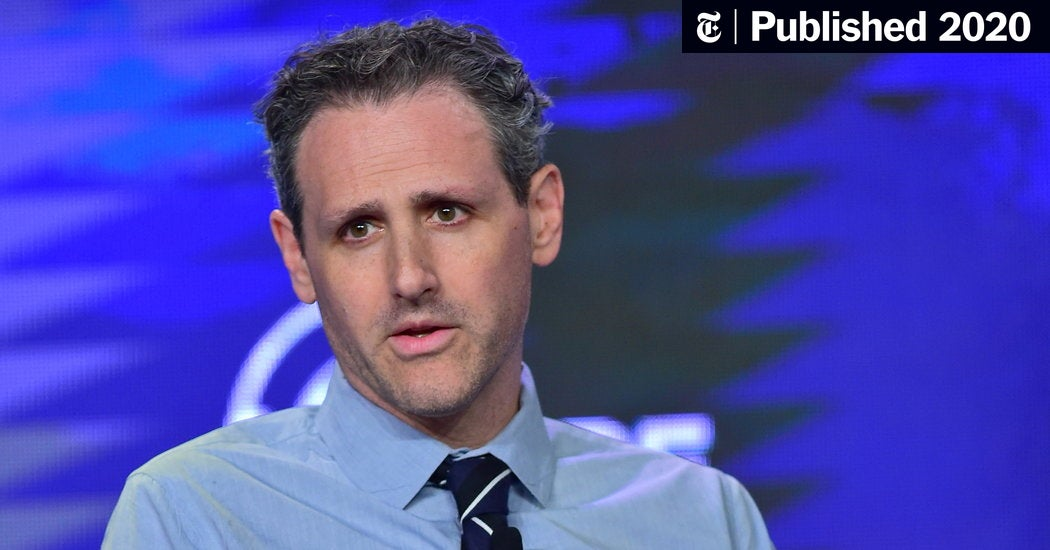

In [95]:
Image.open(train_datasets[1]["image_path"])

In [96]:
print(Image.open(train_datasets[0]["image_path"]))

<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1050x549 at 0x7DFB6427AD10>


In [97]:
train_datasets

Dataset({
    features: ['caption', 'image_path', '__index_level_0__'],
    num_rows: 1680
})

In [41]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        # Load the image from the file path
        image = Image.open(item['image_path']).convert('RGB')

        # Process the image and the caption using your processor
        encoding = self.processor(images=image, text=item['caption'], padding="max_length", return_tensors="pt")

        # Remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}

        return encoding

In [32]:
from transformers import AutoProcessor, BlipForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [43]:
train_dataset = ImageCaptioningDataset(train_datasets, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=16, num_workers=8)

val_dataset = ImageCaptioningDataset(val_datasets, processor)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=16, num_workers=8)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation loss: 0.3746903055244022


Training:   0%|          | 0/105 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation loss: 0.28062432673242355


Training:   0%|          | 0/105 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation loss: 0.2605529997083876


Training:   0%|          | 0/105 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation loss: 0.2589990791347292


Training:   0%|          | 0/105 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Saved new best model with validation loss: 0.25791615313953825


Training:   0%|          | 0/105 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

Training:   0%|          | 0/105 [00:00<?, ?it/s]

Validating:   0%|          | 0/45 [00:00<?, ?it/s]

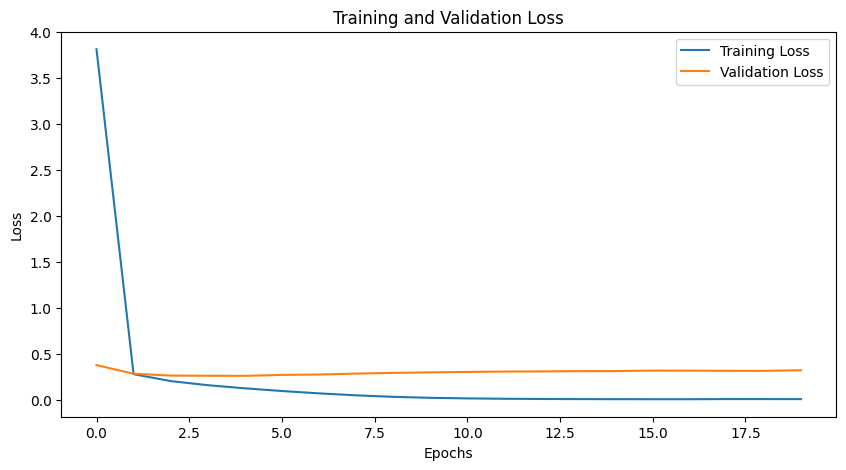

In [102]:
from tqdm.notebook import tqdm

# Initialize the optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# Setup the device
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Lists to store loss values
train_losses = []
val_losses = []

# Variable to track the best validation loss
best_val_loss = float('inf')
# best_model_path = 'best_model.pth'  # Path to save the best model

# Set model to training mode
model.train()

# Create a tqdm progress bar for the epochs
epoch_progress = tqdm(range(20), desc="Epochs")

for epoch in epoch_progress:
    # Set description for the current epoch
    epoch_progress.set_description(f"Epoch {epoch + 1}")

    # Training Phase
    train_loss = 0
    train_steps = 0
    batch_progress = tqdm(train_dataloader, desc="Training", leave=False)

    for idx, batch in enumerate(batch_progress):
        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device)

        outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
        loss = outputs.loss

        batch_progress.set_postfix(loss=loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        train_steps += 1

    # Average training loss for the epoch
    train_loss /= train_steps
    train_losses.append(train_loss)

    # Validation Phase
    model.eval()
    val_loss = 0
    val_steps = 0
    with torch.no_grad():
        for val_batch in tqdm(val_dataloader, desc="Validating", leave=False):
            input_ids = val_batch.pop("input_ids").to(device)
            pixel_values = val_batch.pop("pixel_values").to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=input_ids)
            val_loss += outputs.loss.item()
            val_steps += 1

    val_loss /= val_steps
    val_losses.append(val_loss)

    epoch_progress.set_postfix(train_loss=train_loss, val_loss=val_loss)

    # Check if the current validation loss is the best we've seen
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save the model state
        model.save_pretrained("/content/drive/MyDrive/ColabNotebooks/nlp_project/caption_gen/Image_Captioning_Fine_Tune_BLIP_model")
        print(f"Saved new best model with validation loss: {best_val_loss}")

    model.train()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [36]:
# Caption model and processor
processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained('/content/drive/MyDrive/ColabNotebooks/nlp_project/caption_gen/Image_Captioning_Fine_Tune_BLIP_model')
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


BlipForConditionalGeneration(
  (vision_model): BlipVisionModel(
    (embeddings): BlipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (encoder): BlipEncoder(
      (layers): ModuleList(
        (0-11): 12 x BlipEncoderLayer(
          (self_attn): BlipAttention(
            (dropout): Dropout(p=0.0, inplace=False)
            (qkv): Linear(in_features=768, out_features=2304, bias=True)
            (projection): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): BlipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
      )
    )
    (post_layernorm): LayerNorm((768,), eps=1e-0

In [28]:
test_datasets

Dataset({
    features: ['caption', 'image_path', '__index_level_0__'],
    num_rows: 3000
})

In [29]:
# load image
example = test_datasets[2]
example

{'caption': 'Juliette Vassilkioti, a commercial plant caretaker, washes plant leaves with a solution of water and dish soap to remove scale infestation that may have built up while plants were left alone in recent weeks.',
 'image_path': '/content/imgs/be8f2886-7a98-51c0-844a-e52b2c6d6547.jpg',
 '__index_level_0__': 2515}

In [89]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        image = Image.open(item['image_path']).convert('RGB')

        # Process the image using your processor
        image_encoding = self.processor(images=image, return_tensors="pt")

        # Remove batch dimension added by return_tensors
        image_encoding = {k: v.squeeze(0) for k, v in image_encoding.items()}

        # Return pixel values and captions
        return {
            'pixel_values': image_encoding['pixel_values'],
            'captions': item['caption']
        }


In [90]:
test_dataset = ImageCaptioningDataset(test_datasets, processor)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=32, num_workers=8)

In [91]:
test_dataset.__getitem__(0)

{'pixel_values': tensor([[[ 1.5362,  1.5070,  1.3172,  ..., -1.7923, -1.7923, -1.7923],
          [ 1.4924,  1.3902,  1.0836,  ..., -1.7923, -1.7923, -1.7923],
          [ 1.5216,  1.1566,  1.0690,  ..., -1.7923, -1.7923, -1.7923],
          ...,
          [-0.2010, -0.2740, -0.2302,  ...,  0.2953,  0.2077,  0.2807],
          [-0.0988, -0.2740, -0.2302,  ...,  0.2223,  0.3391,  0.2077],
          [-0.0550, -0.0842, -0.2448,  ...,  0.2807,  0.1347,  0.1493]],
 
         [[ 1.2945,  1.2945,  1.1444,  ..., -1.7221, -1.7221, -1.7221],
          [ 1.2645,  1.1894,  0.9043,  ..., -1.7221, -1.7221, -1.7221],
          [ 1.2945,  0.9643,  0.8893,  ..., -1.7221, -1.7221, -1.7221],
          ...,
          [-0.2513, -0.3114, -0.2363,  ...,  0.2139,  0.1239,  0.1689],
          [-0.1463, -0.3114, -0.2363,  ...,  0.1389,  0.2589,  0.1089],
          [-0.1012, -0.1163, -0.2513,  ...,  0.1989,  0.0638,  0.0488]],
 
         [[ 0.9230,  0.9941,  0.9088,  ..., -1.2385, -1.2385, -1.2385],
          [ 

In [92]:
def generate_captions(data_loader, model, processor):
    model.eval()
    captions_pred = []
    captions_true = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Generating captions"):
            pixel_values = batch['pixel_values'].to(model.device)
            outputs = model.generate(pixel_values)
            captions = [processor.decode(output, skip_special_tokens=True) for output in outputs]

            captions_pred.extend(captions)
            captions_true.extend(batch['captions'])

    return captions_pred, captions_true

# Generate predicted and true captions
captions_pred, captions_true = generate_captions(test_dataloader, model, processor)

Generating captions: 100%|██████████| 94/94 [06:38<00:00,  4.24s/it]


In [93]:
len(captions_pred), len(captions_true)

(2985, 2985)

In [94]:
# Initialize count outside the loop
count = 0

# Iterate over each caption in the list
for caption in captions_pred:
    # Check if the length of the caption is less than 10
    if len(caption) == 0:
        print(caption)  # Print the caption if it's less than 10 characters
        count += 1  # Increment the count

# After the loop, print the total count of captions with fewer than 10 characters
print("Number of captions 0 characters:", count)



Number of captions 0 characters: 1


In [95]:
# Initialize count outside the loop
count = 0

# Iterate over each caption in the list
for caption in captions_true:
    # Check if the length of the caption is less than 10
    if len(caption) == 0:
        print(caption)  # Print the caption if it's less than 10 characters
        count += 1  # Increment the count

# After the loop, print the total count of captions with fewer than 10 characters
print("Number of captions with 0 characters:", count)

Number of captions with 0 characters: 0


In [96]:
# Calculate BERTScore
P, R, F1 = score(captions_pred, captions_true, lang='en', verbose=True)

# Print the BERTScores
print("Precision:", P.mean().item())
print("coverage:", R.mean().item())
print("F1 Score:", F1.mean().item())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/93 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/47 [00:00<?, ?it/s]

done in 33.58 seconds, 88.90 sentences/sec
Precision: 0.8377677798271179
coverage: 0.8279896378517151
F1 Score: 0.8325034976005554


## Evaluation Summary for Image Captioning Model

The evaluation of the image captioning model using BERTScore has revealed several critical issues and results that require attention. The warnings and performance metrics provide valuable insights into the model's behavior and the quality of the generated captions.

### Warnings Observed

During the evaluation, several warnings were issued related to empty candidate and reference sentences:

- **Empty Candidate Sentences**: Warnings indicating empty candidate sentences were detected. This situation arises when the model fails to generate any caption for a given image.

### Performance Metrics

Despite the issues with empty sentences, the model achieved the following BERTScores:

- **Precision**: 0.8377
- **Recall (Coverage)**: 0.8279
- **F1 Score**: 0.832

These scores are relatively high, indicating that when the model does generate captions, they tend to be semantically similar to the reference captions. However, the presence of empty sentences has likely depressed these scores to some extent.



In [41]:
test_df.isnull().sum()

caption       0
image_path    0
dtype: int64

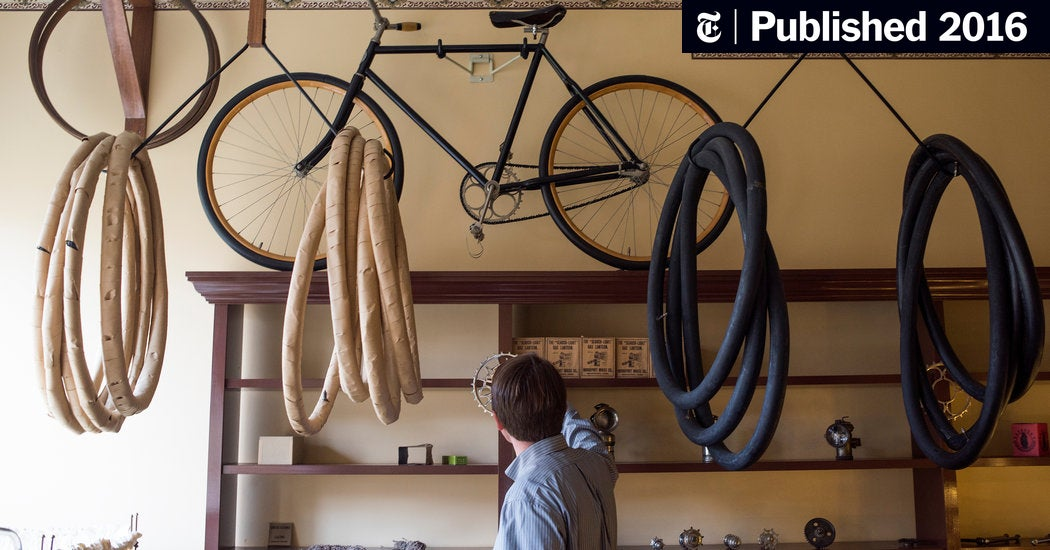

In [112]:
img_example = test_datasets['image_path'][2]
Image.open(img_example)

In [113]:
# prepare image for the model
inputs = processor(images=Image.open(test_datasets['image_path'][2]).convert('RGB'), return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

the man at the counter at the bike shop proclaims that he can buy his bikes online, like these hangings from his shop in san francisco.


# FreePalastain Category

In [145]:
 falastain_cate_df = json_train_data.copy()

## Create New Column Have Number of words from palestine_keywords
- Create conditions detect if there is any word from palestine_keywords are in the arti

In [146]:
palestine_keywords = ['palestine', 'gaza', 'hamas', 'palestinians', 'rafah']

def count_palestine_words(text):
    if pd.isna(text):
        return 0  # Return 0 if the text is NaN
    words = str(text).lower().split()  # Convert text to string and process
    return sum(word in palestine_keywords for word in words)

# Apply the function to create the new column
falastain_cate_df['palestine'] = falastain_cate_df['article'].apply(count_palestine_words)

In [147]:
falastain_cate_df['palestine'].value_counts()

palestine
0     48902
1        53
2        12
6         6
3         5
8         3
5         3
9         2
12        1
4         1
Name: count, dtype: int64

## Test it in the test dataset

In [149]:
# Print the first article that contains any of the keywords
first_article = json_test_data[json_test_data['palestine'] > 0]['article'].iloc[2]
print(first_article)

"For Netanyahu and Israel, Political Presents From Trump Kept Coming" (news article, Nov. 22) evinces a nostalgia for the old U.S. foreign policy consensus on Israel and the Palestinians that is startling for those of us who watched the ineffectiveness of that consensus in real time.

What you characterize as President Trump's "lavish" treatment of Prime Minister Benjamin Netanyahu was something less personal and more political: a break from 40 years of U.S. policy that had tried to bring the Palestinian leadership to the negotiating table and keep it there productively.

A result of these 40 years of efforts was four peace offers the Palestinians rejected, as well as a revivified Hamas in Gaza, attacks in southern Lebanon, two intifadas and unending Palestinian insistence on the right of refugees' descendants to return to Israel, a policy that would use demographics to destroy the Jewish state.

In the face of this history, President Trump's insistence on holding the Palestinians to a